# 1. Introduction

The purpose of this notebook is to synthesize time residuals from pulsar timing. We can simulate time series that contain white Gaussian noise, red Gaussian noise, nuisance effects, and ULDM signals (four types of DM signals are available). In this work, we assume that the measurement moments are equidistant.

This notebook serves as the foundation for other notebooks, which apply autoencoder or binary/multiclass classification techniques to detect ULDM signals.

### Installation and import

In [7]:
# Install a package that enhances the appearance of charts
!pip install scienceplots

In [8]:
# Import basic libraries, functions, etc.
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
import random as rd
import astropy.units as u  
from tqdm import tqdm   
import statistics as st
import scipy.signal
import math
import time

# Import library for data preprocessing (specifically for normalizing datasets during training)
from sklearn.preprocessing import MinMaxScaler

# 2. Pulsar parameters, noise modelling

### 2.1 Pulsar parameters, constants

We list parameters of the pulsar **PSR J1909-3744 (ELL1)**, then the dark matter density.

In [12]:
# psr's name
psr_name = "PSR J1909-3744 (ELL1)"

# Theorized number of data points
n = 1024

# Noise level (1 sigma) in seconds
noise = 1.1776067037715954e-06 * u.s

# Orbital angular frequency of the binary system in radians per day
omega_b = 4.09741925221179 * 1 / u.d
omega_b = omega_b.to(1/u.s)
 
# x = a_1 * sin(iota) (projected semi-major axis of the orbit) in seconds
x = 1.8979910123004033 * u.s

# Start of observation (Modified Julian Date)
Tmin = 53292.01663450055 * u.d

# End of observation (Modified Julian Date)
Tmax = 58950.609463344794 * u.d

# Transit time through the ascending node (Modified Julian Date)
Tasc = 56121.044961418644 * u.d

# eta_0, kappa_0, eccentricity
eta   = 4.46e-8
kappa = -9.91e-8
e = np.sqrt(eta**2 + kappa**2)

# Conversion factor from electronvolts (eV) to inverse seconds (1/s)
conver_factor_eV_to_invs = 1.519e15 / u.s / u.eV

# Orbital angular frequency of the binary system, converted to eV
omega_b_ev = omega_b / conver_factor_eV_to_invs 

# angle
omega = 155.8 * u.deg
omega = omega.to(u.rad).value

# DM density
rhoDM = 0.3 * u.GeV / u.cm**3

### 2.2 Nyquist frequency, frequency resolution

Since the data points lie on a regular grid, we can calculate the minimum (resolution) and maximum (Nyquist) frequency. Later, we generate Gaussian noise in the frequency range given by the resolution and Nyquist frequency. Here we compare these frequencies with the orbital pulsar frequency.

In [15]:
# orbital (non-angular) frequency
f_b = (omega_b / (2 * np.pi))
print("Orbital (non-angular) frequency  = ",  f_b)

Orbital (non-angular) frequency  =  7.547737591544024e-06 1 / s


In [16]:
# frequency resolution: \Delta f = 1 / T
delta_f = 1 / (Tmax - Tmin).to(u.second) 
print("Frequency resolution = " , delta_f)

Frequency resolution =  2.0453979326938167e-09 1 / s


In [17]:
# Nyquist frequency
f_nq = 0.5 * n * delta_f
print("Nyquist frequency = ", f_nq)

Nyquist frequency =  1.0472437415392342e-06 1 / s


In [18]:
# Does the orbital frequency lie in the frequency window?
print("Does the orbital frequency lie in the frequency window? ", f_b < f_nq)

Does the orbital frequency lie in the frequency window?  False


In [19]:
# n (number of data points) so the orbital frequency = Nyquist frequency
n_min = 2 * f_b / delta_f
print("n so the \'orbital frequency\' = \'Nyquist frequency\': ", (round(float(n_min))))
print("Given number of data points = ", n)

n so the 'orbital frequency' = 'Nyquist frequency':  7380
Given number of data points =  1024


In [20]:
# in eV

# resolution
f_min = delta_f
omega_min = 2*np.pi * f_min
m_min = omega_min / conver_factor_eV_to_invs

# Nyquist
f_max = f_nq
omega_max = 2*np.pi * f_max
m_max = omega_max / conver_factor_eV_to_invs

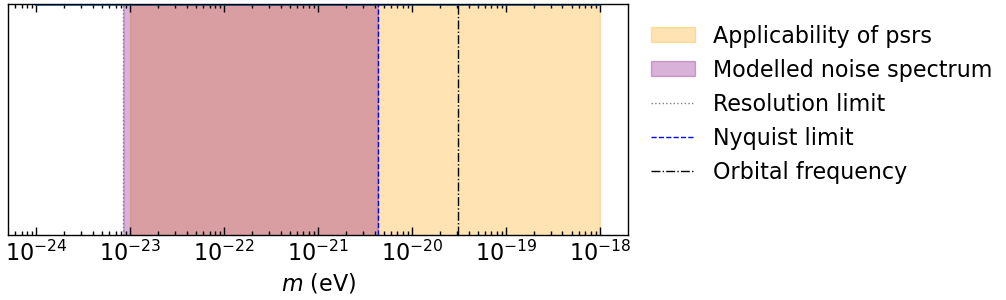

In [21]:
# summary of all above in a graph

plt.figure(figsize=(8, 3))

# Define the range for the x-axis
m_ran_exp = np.linspace(-24, -18, 10000)
m_ran = 10**m_ran_exp

# Define the y-value for the horizontal line
y = 10.0  # or any constant value you want for the y-axis

plt.fill_between(m_ran, y, where=(m_ran >= 1e-23) & (m_ran <= 1e-18), color='orange', alpha=0.3, label = "Applicability of psrs")
plt.fill_between(m_ran, y, where=(m_ran >= m_min.value) & (m_ran <= m_max.value), color='purple', alpha=0.3, label = "Modelled noise spectrum")

# Plot the horizontal line
plt.plot(m_ran, np.full_like(m_ran, y))
plt.xscale('log')
plt.xlabel(r'$m$ (eV)')

plt.axvline(x=m_min.value, color='grey', linestyle=':', linewidth=1, label="Resolution limit")
plt.axvline(x=m_max.value, color='blue', linestyle='--', linewidth=1, label="Nyquist limit")
plt.axvline(x=omega_b_ev.value, color='black', linestyle='-.', linewidth=1, label="Orbital frequency")

# Adjust the legend position
plt.legend(loc="upper right", bbox_to_anchor=(1.62, 1))

# Set y-axis limits to [0, 1]
plt.ylim(1, 10)

# Turn off y-axis scale (ticks and labels)
plt.yticks([])

plt.show()

### 2.3 Times of arrival, angle $\Psi'$

We will model the arrival times of the pulses lying on the equidistant grid. Then we will generate Gaussian noise (white, red, combination).

Theorized times of arrival

In [25]:
# Simulated Times of Arrival (TOA)
TOA_sim_array = []

# Assume TOAs lie on a uniformly spaced grid
for j in range(n):
    T = Tmin + (Tmax - Tmin) / (n - 1) * j  # Calculate TOA for each step
    TOA_sim_array.append(T.value)

# Convert the list to a NumPy array and retain the original time unit
TOA_sim_array = np.array(TOA_sim_array) * Tmin.unit

# Print the number of simulated TOAs and display a few components
print("Number of TOAs = " + str(len(TOA_sim_array)) + "\n\nA few components:")
TOA_sim_array[:4]  # Display the first four simulated TOAs

Number of TOAs = 1024

A few components:


<Quantity [53292.0166345 , 53297.54800579, 53303.07937708, 53308.61074837] d>

Computation of the angle $\Psi'$ for a given time $t$: $\Psi' = \omega_b (t - T_{\mathrm{asc}})$

In [27]:
# Compute the angle Psi'
def psi_i(omegab, t_asc, t):

    omegab = omegab.to(1 / u.s)  # Convert angular frequency to 1/s
    t_asc = t_asc.to(u.s)        # Convert Tasc to seconds
    t = t.to(u.s)                # Convert TOA to seconds
    
    return omegab * (t - t_asc)  # Compute and return the angle Psi'

### 2.4 Noise generator

A. Using the Cholesky decomposition

Generating a noise sequence for a given correlation matrix

In [31]:
def generate_gaussian_process_from_matrix(correlation_matrix):
   
    # Cholesky decomposition
    L = np.linalg.cholesky(correlation_matrix + 1e-10 * np.eye(correlation_matrix.shape[0]))  # Stability adjustment

    # Generate uncorrelated Gaussian samples
    n_points = correlation_matrix.shape[0]
    z = np.random.normal(size=n_points)

    # Generate correlated samples
    process = L @ z
    return process

Particular noise type

In [33]:
def generate_noise_process(type = 'white', times = np.array(TOA_sim_array.to(u.year)), f_0 = 1):
    if type == 'white':
        correlation_matrix = np.eye(n)
    if type == 'red':
        correlation_matrix = np.exp(-f_0 * 2  *np.pi * np.abs(np.subtract.outer(times, times)))
    gaussian_process = generate_gaussian_process_from_matrix(correlation_matrix)
    sigma = st.stdev(gaussian_process) 
    gaussian_process = noise.value * gaussian_process / sigma
    return gaussian_process

Examples

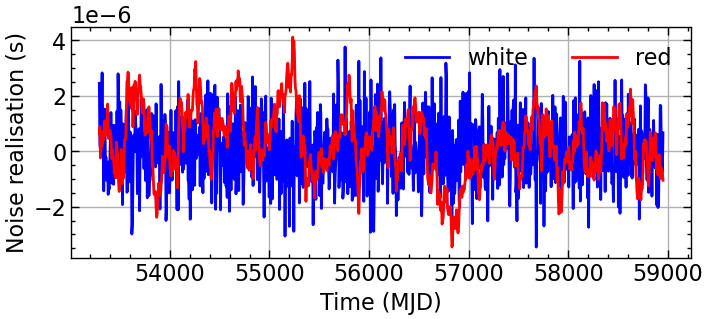

In [35]:
white_process = generate_noise_process(type = 'white')
red_process   = generate_noise_process(type = 'red')

# Plot the results
plt.figure(figsize=(8, 3))
plt.plot(TOA_sim_array, white_process, color = "blue", label = "white")
plt.plot(TOA_sim_array, red_process, color = "red", label = "red")
plt.xlabel("Time (MJD)")
plt.ylabel("Noise realisation (s)")
plt.grid()
plt.legend(loc = 'upper right', ncol = 2)
plt.show()

Sampling frequency

In [37]:
duration = Tmax.to(u.s) - Tmin.to(u.s)
fs = n / duration

B. Using a library

We aim to employ this library: https://pypi.org/project/pyplnoise/, which can generate single-color Gaussian noise.

In [40]:
# install pyplnoise library
!pip install pyplnoise 

# import the library
import pyplnoise

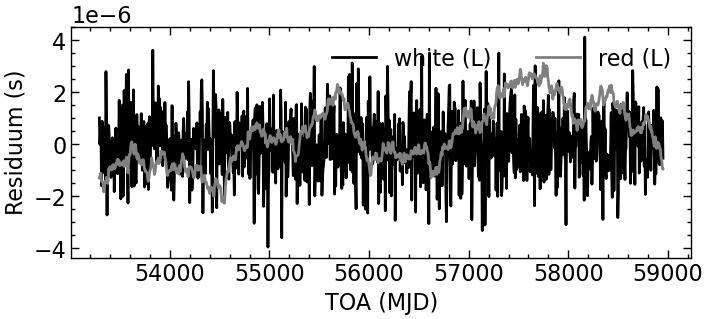

In [41]:
# white/red noise models
white_noise_model = pyplnoise.WhiteNoise(f_sample = fs.value)
red_noise_model   = pyplnoise.RedNoise(f_sample = fs.value, f_min = f_min.value)

# a particular realisation of white/red noise (n points)
noise_white       = white_noise_model.get_series(n)
noise_red         = red_noise_model.get_series(n)

# its std deviation
sigma_w = st.stdev(noise_white)
sigma_r = st.stdev(noise_red) 

# correct normalization
noise_white = noise.value * noise_white / sigma_w
noise_red   = noise.value * noise_red / sigma_r


plt.figure(figsize=(8, 3))
plt.plot(TOA_sim_array, noise_white, color = "black", label = "white (L)")
plt.plot(TOA_sim_array, noise_red, color = "grey", label = "red (L)")

plt.xlabel("TOA (MJD)")
plt.ylabel("Residuum (s)")

plt.legend(loc = 'upper right', ncol = 2)
plt.show()


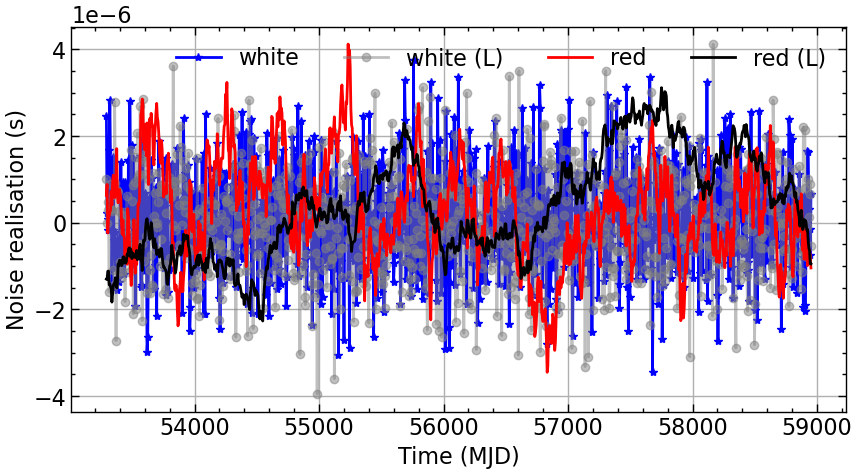

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(TOA_sim_array, white_process, "*-", color = "blue", label = "white")
plt.plot(TOA_sim_array, noise_white, "o-", color = "grey", label = "white (L)", alpha = 0.5)
plt.plot(TOA_sim_array, red_process, color = "red", label = "red")
plt.plot(TOA_sim_array, noise_red, color = "black", label = "red (L)")
plt.xlabel("Time (MJD)")
plt.ylabel("Noise realisation (s)")
plt.legend(loc = 'upper right', ncol = 4)
plt.grid()
plt.show()

Power spectral density

In [44]:
def theory_power_spectral_density(freq, type = 'white', times = np.array(TOA_sim_array.to(u.year)), f_0 = 1):
    if type == 'white':
        f_0 = f_0 / (365.24 * 24 *3600)
        return noise.value**2 * np.ones(len(freq)) / fs
    if type == 'red':
        f_0 = f_0 / (365.24 * 24 *3600)
        return noise.value**2 / ( f_0 * ( 1 + (freq / f_0)**2 ) ) 

Example

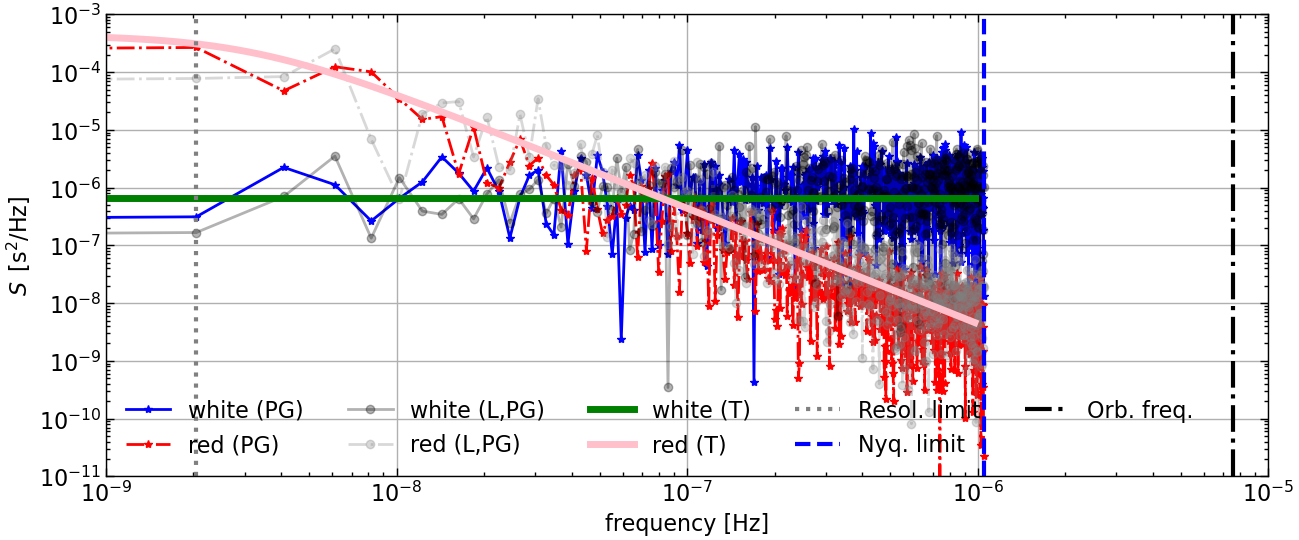

In [46]:
# https://www.scicoding.com/calculating-power-spectral-density-in-python/
f0 = 0.1
# Approch A
noise_white_A = generate_noise_process(type = 'white')
noise_red_A   = generate_noise_process(type = 'red', f_0 = f0)

# Approch B
white_noise_model = pyplnoise.WhiteNoise(f_sample = fs.value)
red_noise_model   = pyplnoise.RedNoise(f_sample = fs.value, f_min = f_min.value)

noise_white_B = white_noise_model.get_series(n)
noise_red_B   = red_noise_model.get_series(n)

sigma_w = st.stdev(noise_white_B)
sigma_r = st.stdev(noise_red_B) 

noise_white_B = noise.value * noise_white_B / sigma_w
noise_red_B   = noise.value * noise_red_B / sigma_r

#  A - PSD computed using the periodogram method
(fwA, SwA) = scipy.signal.periodogram(noise_white_A, fs.value, scaling='density')
(frA, SrA) = scipy.signal.periodogram(noise_red_A, fs.value, scaling='density')

#  B - PSD computed using the periodogram method
(fwB, SwB) = scipy.signal.periodogram(noise_white_B, fs.value, scaling='density')
(frB, SrB) = scipy.signal.periodogram(noise_red_B, fs.value, scaling='density')

# A - PSD computed using the Welch's method (approximation)
# NOT USED
#(fwA2, SwA2)= scipy.signal.welch(noise_white_A, fs.value, nperseg=4*1024)
#(frA2, SrA2)= scipy.signal.welch(noise_red_A, fs.value, nperseg=4*1024)

# PSD from theory
log_freq_range = np.linspace(-9,-5,100)
freq_range = 10**log_freq_range
freq_range = freq_range[freq_range < f_max.value]
Swt = theory_power_spectral_density(freq_range, type = 'white')
Srt = theory_power_spectral_density(freq_range, type = 'red', f_0 = f0)

# Plots
plt.figure(figsize=(15, 6))
plt.semilogy(fwA, SwA, alpha = 1, label = "white (PG)", color = "blue",  linestyle="-", marker="*")
plt.semilogy(frA, SrA, alpha = 1, label = "red (PG)", color = "red",  linestyle="-.", marker="*")
plt.semilogy(fwB, SwB, alpha = 0.3, label = "white (L,PG)", color = "black",  linestyle="-", marker="o")
plt.semilogy(frB, SrB, alpha = 0.3, label = "red (L,PG)", color = "grey",  linestyle="-.", marker="o")
plt.plot(freq_range, Swt, linewidth=5, label = "white (T)", color = "green")
plt.plot(freq_range, Srt, linewidth=5, label = "red (T)", color = "pink")

plt.axvline(x=f_min.value, color='grey', linestyle=':', linewidth=3, label="Resol. limit")
plt.axvline(x=f_max.value, color='blue', linestyle='--', linewidth=3, label="Nyq. limit")
plt.axvline(x=f_b.value, color='black', linestyle='-.', linewidth=3, label="Orb. freq.")

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-9, 1e-5])
plt.ylim([1e-11, 1e-3])

plt.xlabel('frequency [Hz]')
plt.ylabel(r'$S\,\,\,\mathrm{[s^2/Hz]}$')
plt.legend(ncol = 5)

plt.grid()
plt.show()

The library gives the same outcome if $f_0 = 0.1$ $\mathrm{yr}^{-1}$.

Let's compare the times required to generate noise in both ways.

In [49]:
# our implementation - white noise
start_time = time.time()
noise_red_A   = generate_noise_process(type = 'white')
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.08622860908508301 seconds


In [50]:
# our implementation - red noise
start_time = time.time()
noise_red_A   = generate_noise_process(type = 'red', f_0 = 0.1)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.14369750022888184 seconds


In [51]:
# library - white noise
start_time = time.time()
white_noise_model = pyplnoise.WhiteNoise(f_sample = fs.value)
noise_white_B = white_noise_model.get_series(n)
sigma_w = st.stdev(noise_white_B)
noise_white_B = noise.value * noise_white_B / sigma_w
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.00498652458190918 seconds


In [52]:
# library - red noise
start_time = time.time()
red_noise_model   = pyplnoise.RedNoise(f_sample = fs.value, f_min = f_min.value)
noise_red_B   = red_noise_model.get_series(n)
sigma_r = st.stdev(noise_red_B) 
noise_red_B   = noise.value * noise_red_B / sigma_r
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.0069811344146728516 seconds


The library can provide us the noise much faster.

New implementatin of white/red noise for faster computations.

In [55]:
def white_gauss_noise_gen():
    return np.random.normal(loc=0.0, scale=noise.value, size=n)

In [56]:
# red noise
times_converted = np.array(TOA_sim_array.to(u.year))
subst_timetime = 2  *np.pi * np.abs(np.subtract.outer(times_converted, times_converted))
f_0 = 1 # it is a fixed value to match the paper Haasteren (2009)
correlation_matrix_lorentzian = np.exp(-f_0 * subst_timetime)
L_lorentzian = np.linalg.cholesky(correlation_matrix_lorentzian + 1e-10 * np.eye(correlation_matrix_lorentzian.shape[0]))

def red_gauss_noise_gen():
    z = np.random.normal(loc=0.0, size=n)
    gaussian_process = L_lorentzian @ z
    sigma = st.stdev(gaussian_process) 
    gaussian_process = noise.value * gaussian_process / sigma
    return gaussian_process

In [57]:
# new implementatin - white noise
start_time = time.time()

noise_red_C = white_gauss_noise_gen()

# Record the end time
end_time = time.time()

# Calculate elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.0010066032409667969 seconds


In [58]:
# new implementatin - red noise
start_time = time.time()

noise_red_C = red_gauss_noise_gen()

# Record the end time
end_time = time.time()

# Calculate elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.00498652458190918 seconds


Example

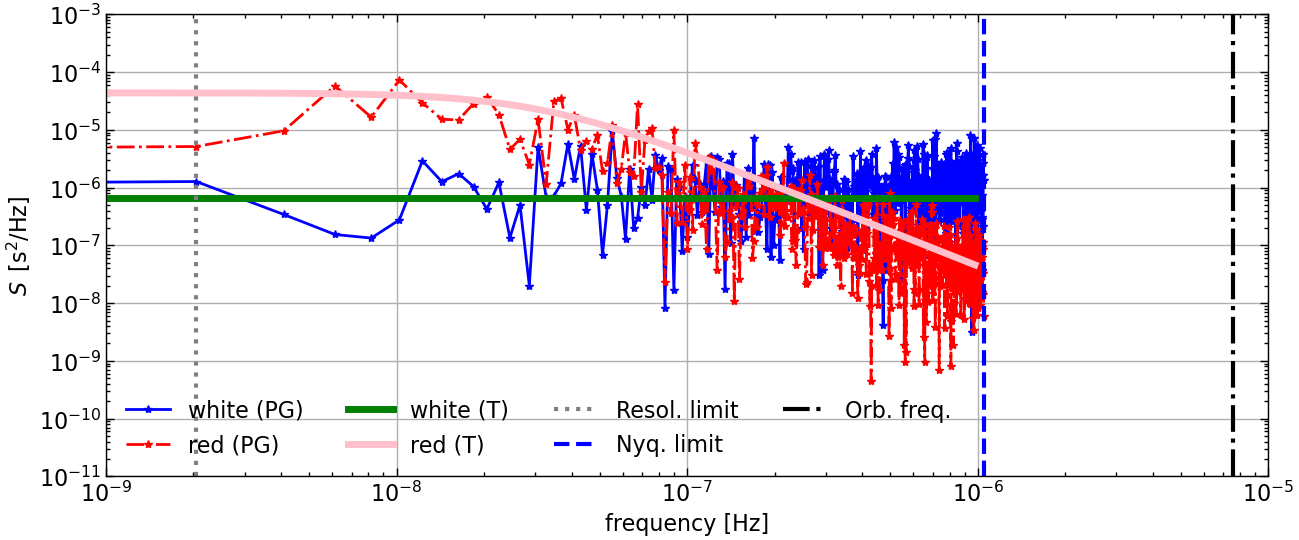

In [60]:
noise_white_C = white_gauss_noise_gen()
noise_red_C   = red_gauss_noise_gen()

# PSD from the new implementation
(fwC, SwC) = scipy.signal.periodogram(noise_white_C, fs.value, scaling='density')
(frC, SrC) = scipy.signal.periodogram(noise_red_C, fs.value, scaling='density')

# PSD from theory
log_freq_range = np.linspace(-9,-5,100)
freq_range = 10**log_freq_range
freq_range = freq_range[freq_range < f_max.value]
Swt = theory_power_spectral_density(freq_range, type = 'white')
Srt = theory_power_spectral_density(freq_range, type = 'red', f_0 = f_0)

# Plots
plt.figure(figsize=(15, 6))
plt.semilogy(fwC, SwC, alpha = 1, label = "white (PG)", color = "blue",  linestyle="-", marker="*")
plt.semilogy(frC, SrC, alpha = 1, label = "red (PG)", color = "red",  linestyle="-.", marker="*")
plt.plot(freq_range, Swt, linewidth=5, label = "white (T)", color = "green")
plt.plot(freq_range, Srt, linewidth=5, label = "red (T)", color = "pink")

plt.axvline(x=f_min.value, color='grey', linestyle=':', linewidth=3, label="Resol. limit")
plt.axvline(x=f_max.value, color='blue', linestyle='--', linewidth=3, label="Nyq. limit")
plt.axvline(x=f_b.value, color='black', linestyle='-.', linewidth=3, label="Orb. freq.")

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-9, 1e-5])
plt.ylim([1e-11, 1e-3])

plt.xlabel('frequency [Hz]')
plt.ylabel(r'$S\,\,\,\mathrm{[s^2/Hz]}$')
plt.legend(ncol = 4)

plt.grid()
plt.show()

Let us create $n$ realizations of white noise and $n$ realizations of red noise:
$$
n = \alpha_w n_w + \alpha_w n_r\,,
$$
where $\alpha_w, \alpha_r$ are weights. Then the combined covariance matrix should be:
$$
C_c = \alpha_w^2 C_w + \alpha_w^2 C_r\,.
$$

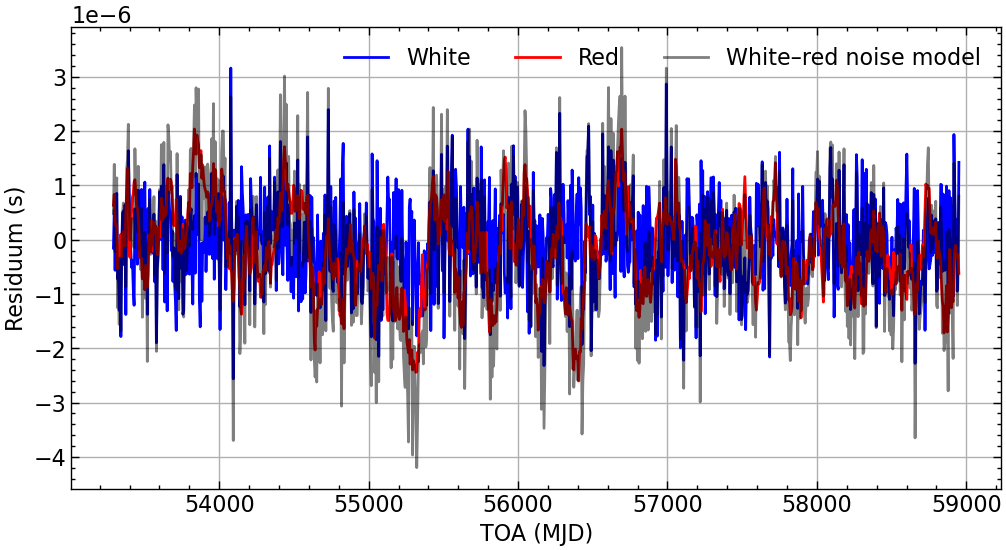

In [62]:
# generate white and red noise realisations
noise_w =  white_gauss_noise_gen()
noise_r =  red_gauss_noise_gen()

# in 1st step, sum them
noise_c = noise_w + noise_r
std_noise_c = st.stdev(noise_c)

# now normalize the sum
# both white and red noise has the same strength here
noise_c = noise.value * noise_c / std_noise_c

plt.figure(figsize=(12, 6))
plt.plot(TOA_sim_array, noise_w * noise.value / std_noise_c, label = "White", color = "blue")
plt.plot(TOA_sim_array, noise_r  * noise.value / std_noise_c, label = "Red", color = "red")

plt.plot(TOA_sim_array, noise_c, label = "White–red noise model", color = "black", alpha = 0.5)
plt.xlabel("TOA (MJD)")
plt.ylabel("Residuum (s)")
plt.legend(loc="upper right", ncol = 3)

# Save the figure with high resolution
plt.savefig("store/plots/white_red_whiteplusred_noise.png", dpi=300)

plt.grid()
plt.show()

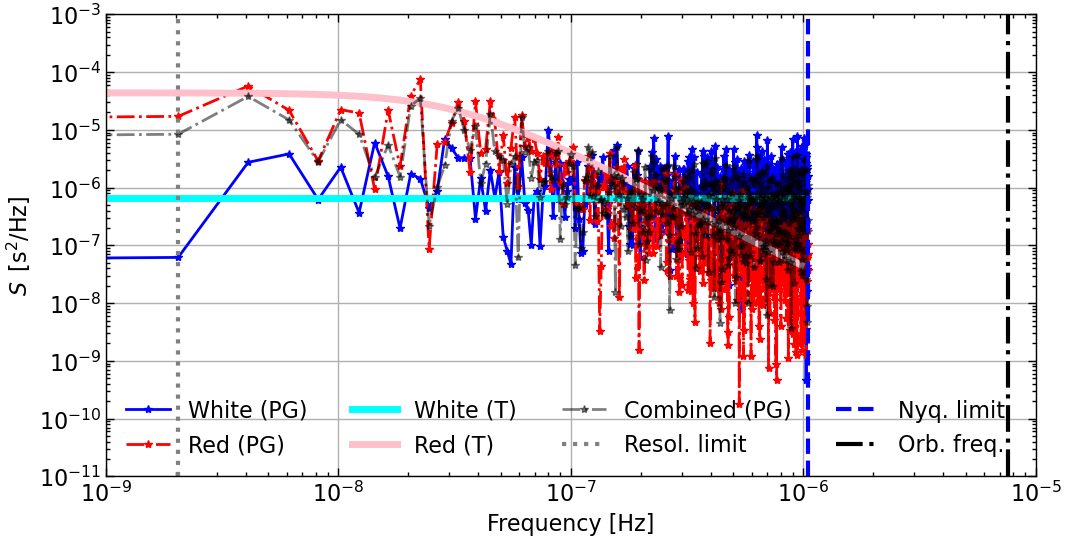

In [63]:
# PSD from the new implementation
(fw, Sw) = scipy.signal.periodogram(noise_w, fs.value, scaling='density')
(fr, Sr) = scipy.signal.periodogram(noise_r, fs.value, scaling='density')
(fc, Sc) = scipy.signal.periodogram(noise_c, fs.value, scaling='density')

# PSD from theory
log_freq_range = np.linspace(-9,-5,100)
freq_range = 10**log_freq_range
freq_range = freq_range[freq_range < f_max.value]
Swt = theory_power_spectral_density(freq_range, type = 'white')
Srt = theory_power_spectral_density(freq_range, type = 'red', f_0 = f_0)

# Plots
plt.figure(figsize=(12, 6))
plt.semilogy(fw, Sw, alpha = 1, label = "White (PG)", color = "blue",  linestyle="-", marker="*")
plt.semilogy(fr, Sr, alpha = 1, label = "Red (PG)", color = "red",  linestyle="-.", marker="*")

plt.plot(freq_range, Swt, linewidth=5, label = "White (T)", color = "cyan")
plt.plot(freq_range, Srt, linewidth=5, label = "Red (T)", color = "pink")

plt.semilogy(fc, Sc, alpha = 0.5, label = "Combined (PG)", color = "black",  linestyle="-.", marker="*")


plt.axvline(x=f_min.value, color='grey', linestyle=':', linewidth=3, label="Resol. limit")
plt.axvline(x=f_max.value, color='blue', linestyle='--', linewidth=3, label="Nyq. limit")
plt.axvline(x=f_b.value, color='black', linestyle='-.', linewidth=3, label="Orb. freq.")

plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-9, 1e-5])
plt.ylim([1e-11, 1e-3])

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$S\,\,\,\mathrm{[s^2/Hz]}$')
plt.legend(ncol = 4)
plt.savefig("store/plots/spower_spectral_density.png", dpi=300)
plt.grid()
plt.show()

In [64]:
# noise generating function

def combined_noise_gen():
    noise_w =  white_gauss_noise_gen()
    noise_r =  red_gauss_noise_gen()

    noise_c = noise_w + noise_r

    # normalisation
    noise_c = noise.value * noise_c / st.stdev(noise_c)

    return noise_c

In [65]:
# new implementatin - red noise
start_time = time.time()

noise_comb = combined_noise_gen()

# Record the end time
end_time = time.time()

# Calculate elapsed time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.012349367141723633 seconds


# 3. ULDM signal, nuisance parameters

We model time residuals originating from ULDM that were not modeled during the initial fitting. 

### 3.1 Nuisance functions

In addition to Gaussian noise, there are other contributions. In this work, we consider the following deterministic contributions:

\begin{equation}
R_i^{\mathrm{det}} = K_0 + K_1 (t_i - T_\mathrm{asc}) + K_2 (t_i - T_\mathrm{asc})^2 +  \sin (\Psi'_i) \delta x_i  - x \frac{\cos(2\Psi'_i) + 3}{2} \delta \eta_i + x \frac{\sin(2\Psi'_i)}{2} \delta \kappa_i   \,,
\end{equation}

where $\delta x_i, \delta \kappa_i, \delta \eta_i$ has several contributions:

\begin{align}
    \delta x_i &= \delta x_0 + A_x (t_i - T_\mathrm{asc}) + \delta x_i^{\mathrm{DM}} \,, \\
    \delta \eta_i &= \delta \eta_0 + A_\eta (t_i - T_\mathrm{asc}) + \delta \eta_i^{\mathrm{DM}} \,, \\
    \delta \kappa_i &= \delta \kappa_0 + A_\kappa (t_i - T_\mathrm{asc}) + \delta \kappa_i^{\mathrm{DM}} \,.
\end{align}

The last six parameters, $\delta x_0, \delta \eta_0, \delta \kappa_0$ and $A_x, A_\eta, A_\kappa$, we refer as the nuisance parameters. The functions of time, which mupliply them, are below:

In [70]:
# this is multiplied by the nuisance parameter x_0 (constant contribution)
def cx_i(t):
  psi = np.array(psi_i(omega_b, Tasc, t))
  return np.sin(psi)

# this is multiplied by the nuisance paramter A_x (contribution linear in time)
def lx_i(t):
  return cx_i(t) * (t-Tasc).to(u.s)

# this is multiplied by the nuisance parameter eta_0 (constant contribution)
def ceta_i(t):
  psi = np.array(psi_i(omega_b, Tasc, t))
  return -x*(np.cos(2*psi) + 3) / 2

# this is multiplied by the nuisance paramter A_eta (contribution linear in time)
def leta_i(t):
  return ceta_i(t) * (t-Tasc).to(u.s)

# this is multiplied by the nuisance parameter eta_0 (constant contribution)
def ckappa_i(t):
  psi = np.array(psi_i(omega_b, Tasc, t))
  return x*np.sin(2*psi) / 2

# this is multiplied by the nuisance paramter A_eta (contribution linear in time)
def lkappa_i(t):
  return ckappa_i(t) * (t-Tasc).to(u.s)

### 3.2 Spin-0 linear signal modelling

\begin{align*}
    \alpha \Phi_0 &= \lambda \times 3.92 \times 10^{-12} \left(\frac{m}{\mathrm{eV}} \right)^{-1} \times \sqrt{\frac{\rho_{\mathrm{DM}}}{\mathrm{GeV/cm^3}}}\,
\end{align*}
where $\lambda = \frac{\alpha}{\mathrm{GeV}^{-1}}$

In [73]:
def alphaphi0(lamb, m):
    return lamb * 3.92e-12 / (m.to(u.eV).value) * np.sqrt(rhoDM.to(u.GeV/u.cm**3).value)

\begin{align}
    \delta x^{\mathrm{DM0\alpha}} = &- 2 \alpha \Phi_0 x \varrho \left[ \cos(k \Psi' + \Upsilon_{\mathrm{asc}}) -  \cos\Upsilon_{\mathrm{asc}} \right]
\end{align}

In [75]:
def delta_x_s0l(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor = np.cos(k*psi + upsilon) - np.cos(upsilon)
    
    result = -2 * alphaphi0(lamb, m) * x.to(u.s) * rho * factor

    return result

\begin{align}
    \delta \eta^{\mathrm{DM0\alpha}} = &+\alpha \Phi_0 \varrho \left( \frac{1}{2} + k \right) \frac{\sin\left[(k-1)\Psi' + \Upsilon_\mathrm{asc}\right] - \sin \Upsilon_\mathrm{asc}}{k-1} \nonumber \\
    &+ \alpha \Phi_0 \varrho \left( \frac{1}{2} - k \right) \frac{\sin\left[(k+1)\Psi' + \Upsilon_\mathrm{asc}\right] - \sin \Upsilon_\mathrm{asc}}{k+1}
    \end{align}

In [77]:
def delta_eta_s0l(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = (0.5 + k) * ( np.sin((k-1)*psi + upsilon) - np.sin(upsilon) ) / (k - 1)

    factor_2 = (0.5 - k) * ( np.sin((k+1)*psi + upsilon) - np.sin(upsilon) ) / (k + 1)
    
    result = alphaphi0(lamb, m) * rho * (factor_1 + factor_2)

    return result

\begin{align}
    \delta \kappa^{\mathrm{DM0\alpha}} = &+\alpha \Phi_0 \varrho \left( \frac{1}{2} + k \right) \frac{\cos \Upsilon_\mathrm{asc} - \cos\left[(k-1)\Psi' + \Upsilon_\mathrm{asc}\right]}{k-1}\, \nonumber \\
    &- \alpha \Phi_0 \varrho \left( \frac{1}{2} - k \right)\frac{\cos \Upsilon_\mathrm{asc} - \cos\left[(k+1)\Psi' + \Upsilon_\mathrm{asc}\right]}{k+1}\,,
\end{align}

In [79]:
def delta_kappa_s0l(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = (0.5 + k) * ( np.cos(upsilon) - np.cos((k-1)*psi + upsilon) ) / (k - 1)

    factor_2 = (0.5 - k) * ( np.cos(upsilon) - np.cos((k+1)*psi + upsilon) ) / (k + 1)
    
    result = alphaphi0(lamb, m) * rho * (factor_1 - factor_2)

    return result

\begin{equation}
R_i^{\mathrm{binary}} = \sin (\Psi'_i) \delta x_i - x\frac{\cos(2\Psi'_i) + 3}{2} \delta \eta_i +  x\frac{\sin(2\Psi'_i)}{2} \delta \kappa_i\,,
\end{equation}

In [81]:
def residuum_s0l(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon):
    
    x_contribution     = np.sin(psi) * delta_x_s0l(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon)
    eta_contribution   = - x * (np.cos(2*psi) + 3) / 2 * delta_eta_s0l(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon)
    kappa_contribution = x * np.sin(2*psi) / 2 * delta_kappa_s0l(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon) 
    
    result = x_contribution + eta_contribution + kappa_contribution
    return result

Bayesian line

In [83]:
def lambda_s0l(x, omega_b, m, rhoDM, rho, upsilon):
  omega_b_ev = omega_b.to(1/u.s) / conver_factor_eV_to_invs
  psi = np.array(psi_i(omega_b, Tasc, TOA_sim_array))

  Q_vector = residuum_s0l(1, x, m, rhoDM, rho, omega_b_ev, psi, upsilon)
  Q_array = np.array(Q_vector) * u.s
  Q_length = np.sqrt( np.dot(Q_array,Q_array) )

  result = np.sqrt(np.log(1000)) * noise / Q_length

  return result

Text(0.5, 1.0, 'PSR J1909-3744 (ELL1), $\\delta x; \\delta \\eta, \\delta \\kappa$ combined')

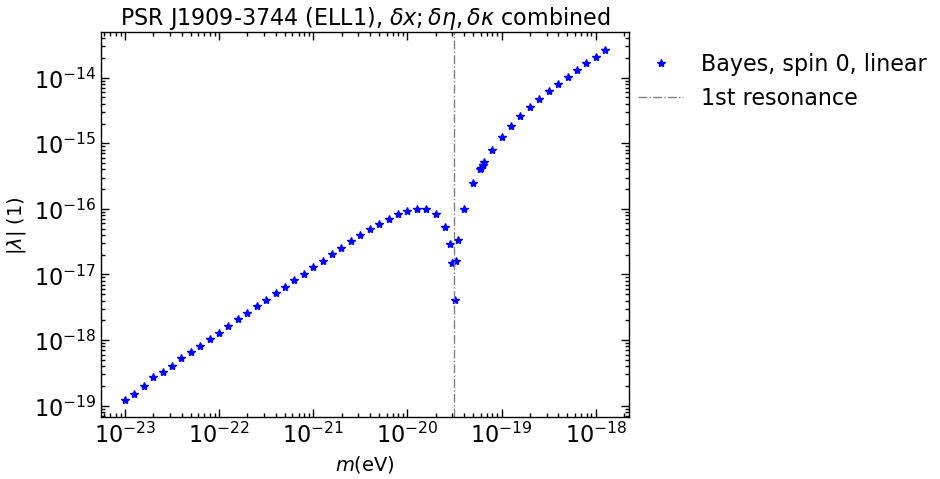

In [84]:
# ULDM amplitude, phase
r_ex = 1
upsasc_ex = np.pi/4

# considered mass interval
mass_list = list(10**np.arange(-23,-17.9,0.1)) + [0.9 * omega_b_ev.value, 0.95 * omega_b_ev.value, 1.05 * omega_b_ev.value, 1.1 * omega_b_ev.value]  + [1.9 * omega_b_ev.value, 1.95 * omega_b_ev.value, 2.05 * omega_b_ev.value, 2.1 * omega_b_ev.value]
sorted(mass_list)
mass_array = np.array(mass_list) * u.eV

# lambda values
lamb_sensitivity_s0l = np.array([lambda_s0l(x, omega_b, m, rhoDM, r_ex, upsasc_ex) for m in mass_array])

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(15, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m$(eV)', fontsize=14)
plt.ylabel(r'$|\lambda|$ (1)', fontsize=14)
plt.plot(mass_array, lamb_sensitivity_s0l, "*", label="Bayes, spin 0, linear", color = "blue")
plt.axvline(x=omega_b_ev.value, color='grey', linestyle='-.', linewidth=1, label="1st resonance")
plt.legend(loc="upper right", bbox_to_anchor=(1.6, 1))
plt.title(psr_name + r", $\delta x; \delta \eta, \delta \kappa$ combined")

### 3.3 Spin-0 quadratic signal modelling

\begin{align*}
    \beta \Phi_0^{2} = \lambda \times 1.54 \times 10^{-23} \left(\frac{m}{\mathrm{eV}} \right)^{-2} \times \frac{\rho_{\mathrm{DM}}}{\mathrm{GeV/cm^3}} 
\end{align*}
where $\lambda = \frac{\beta}{\mathrm{GeV}^{-2}}$

In [87]:
def betaphi20(lamb, m):
    return lamb * 1.54e-23 / (m.to(u.eV).value)**2 * rhoDM.to(u.GeV/u.cm**3).value

\begin{align}
     \delta x^{\mathrm{DM0\beta}} &=  - \beta \Phi_0^2 x \varrho^2 \left[ \cos^2(k \Psi' + \Upsilon_{\mathrm{asc}}) - \cos^2\Upsilon_{\mathrm{asc}} \right]\,.
\end{align}

In [89]:
def delta_x_s0q(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor = np.cos(k*psi + upsilon)**2 - np.cos(upsilon)**2
    
    result = - betaphi20(lamb, m) * x.to(u.s) * rho**2 * factor

    return result

\begin{align}
    \delta \eta^{\mathrm{DM0\beta}} = &+ \frac{\beta \Phi_0^2 \varrho^2}{4} \sin \Psi' \nonumber\\
    &+ \frac{\beta \Phi_0^2 \varrho^2}{2}\left( k +  \frac{1}{4} \right) \frac{\sin\left[(2k-1)\Psi' + 2\Upsilon_\mathrm{asc}\right] - \sin (2\Upsilon_\mathrm{asc})}{2k-1} \nonumber \\
    &+ \frac{\beta \Phi_0^2 \varrho^2}{2} \left( \frac{1}{4} - k \right) \frac{\sin\left[(2k+1)\Psi' + 2\Upsilon_\mathrm{asc}\right] - \sin (2\Upsilon_\mathrm{asc})}{2k+1}
\end{align}

In [91]:
def delta_eta_s0q(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = 1 / 4 * np.sin(psi)

    factor_2 = 1 / 2 * ( k + 1/4 ) * ( np.sin((2*k-1)*psi + 2*upsilon) - np.sin(2*upsilon) ) / (2 * k - 1)

    factor_3 = 1 / 2 * ( 1/4 - k ) * ( np.sin((2*k+1)*psi + 2*upsilon) - np.sin(2*upsilon) ) / (2 * k + 1)
    
    result = betaphi20(lamb, m) * rho**2 * (factor_1 + factor_2 + factor_3)

    return result

\begin{align}
    \delta \kappa^{\mathrm{DM0\beta}} =&+ \frac{\beta \Phi_0^2 \varrho^2}{4} \left( \cos \Psi' - 1 \right) \nonumber\\
    &+ \frac{\beta \Phi_0^2 \varrho^2}{2}\left( k +  \frac{1}{4} \right) \frac{\cos (2\Upsilon_\mathrm{asc}) - \cos\left[(2k-1)\Psi' + 2\Upsilon_\mathrm{asc}\right]}{2k-1} \nonumber \\
    &- \frac{\beta \Phi_0^2 \varrho^2}{2} \left( \frac{1}{4} - k \right) \frac{\cos (2\Upsilon_\mathrm{asc}) - \cos\left[(2k+1)\Psi' + 2\Upsilon_\mathrm{asc}\right]}{2k+1}\,,
\end{align}

In [93]:
def delta_kappa_s0q(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = 1 / 4 * ( np.cos(psi) - 1 )

    factor_2 = 1 / 2 * ( k + 1/4 ) * ( np.cos(2*upsilon) - np.cos((2*k-1)*psi + 2*upsilon) ) / (2 * k - 1)

    factor_3 = 1 / 2 * ( 1/4 - k ) * ( np.cos(2*upsilon) - np.cos((2*k+1)*psi + 2*upsilon) ) / (2 * k + 1)
    
    result = betaphi20(lamb, m) * rho**2 * (factor_1 + factor_2 - factor_3)

    return result

\begin{equation}
R_i^{\mathrm{binary}} = \sin (\Psi'_i) \delta x_i - x\frac{\cos(2\Psi'_i) + 3}{2} \delta \eta_i +  x\frac{\sin(2\Psi'_i)}{2} \delta \kappa_i\,,
\end{equation}

In [95]:
def residuum_s0q(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon):
    
    x_contribution     = np.sin(psi) * delta_x_s0q(lamb, x, m, rhoDM, rho, omega_b_ev, psi, upsilon)
    eta_contribution   = - x * (np.cos(2*psi) + 3) / 2 * delta_eta_s0q(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon)
    kappa_contribution = x * np.sin(2*psi) / 2 * delta_kappa_s0q(lamb, m, rhoDM, rho, omega_b_ev, psi, upsilon) 
    
    result = x_contribution + eta_contribution + kappa_contribution
    return result

Bayesian line

In [97]:
def lambda_s0q(x, omega_b, m, rhoDM, rho, upsilon):
  omega_b_ev = omega_b.to(1/u.s) / conver_factor_eV_to_invs
  psi = np.array(psi_i(omega_b, Tasc, TOA_sim_array))

  Q_vector = residuum_s0q(1, x, m, rhoDM, rho, omega_b_ev, psi, upsilon)
  Q_array = np.array(Q_vector) * u.s
  Q_length = np.sqrt( np.dot(Q_array,Q_array) )

  result = np.sqrt(np.log(1000)) * noise / Q_length

  return result

Text(0.5, 1.0, 'PSR J1909-3744 (ELL1), $\\delta x; \\delta \\eta, \\delta \\kappa$ combined')

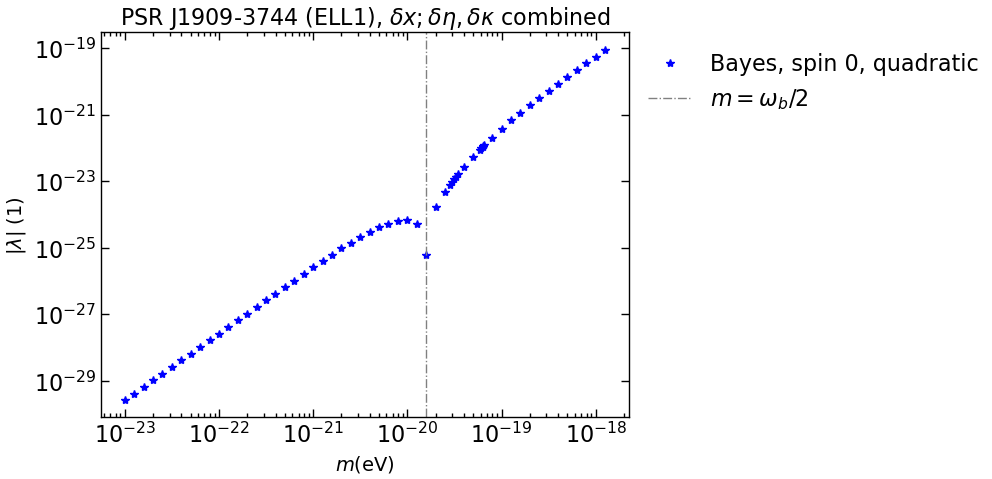

In [98]:
# ULDM amplitude, phase
r_ex = 1
upsasc_ex = np.pi/4

# considered mass interval
mass_list = list(10**np.arange(-23,-17.9,0.1)) + [0.9 * omega_b_ev.value, 0.95 * omega_b_ev.value, 1.05 * omega_b_ev.value, 1.1 * omega_b_ev.value]  + [1.9 * omega_b_ev.value, 1.95 * omega_b_ev.value, 2.05 * omega_b_ev.value, 2.1 * omega_b_ev.value]
sorted(mass_list)
mass_array = np.array(mass_list) * u.eV

# lambda values
lamb_sensitivity_s0q = np.array([lambda_s0q(x, omega_b, m, rhoDM, r_ex, upsasc_ex) for m in mass_array])

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(15, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m$(eV)', fontsize=14)
plt.ylabel(r'$|\lambda|$ (1)', fontsize=14)
plt.plot(mass_array, lamb_sensitivity_s0q, "*", label="Bayes, spin 0, quadratic", color = "blue")
plt.axvline(x = 0.5 * omega_b_ev.value, color='grey', linestyle='-.', linewidth=1, label=r"$m = \omega_b / 2$")
plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1))
plt.title(psr_name + r", $\delta x; \delta \eta, \delta \kappa$ combined")

### 3.4 Spin-1 signal modelling

\begin{align*}
    \Psi' &\equiv \omega_b(t-T_{\mathrm{asc}})\,,~~\Upsilon_{\mathrm{asc}} \equiv \Upsilon + m T_{\mathrm{asc}}\,,~~\varphi_{\mathrm{asc}}^1 \equiv \varphi - \omega\,,~~\varphi_{\mathrm{asc}}^2 \equiv \varphi - 2\omega\,,\\
    S^a &\equiv -\frac{\sin\left[(k+1)\Psi'- \varphi^1_{\mathrm{asc}}\right]+\sin \varphi^1_{\mathrm{asc}}}{k+1} + \frac{\sin\left[(k-1)\Psi'+ \varphi^1_{\mathrm{asc}}\right]-\sin \varphi^1_{\mathrm{asc}}}{k-1}\,,\\
    C^a &\equiv -\frac{\cos\left[(k+1)\Psi'- \varphi^1_{\mathrm{asc}}\right]-\cos \varphi^1_{\mathrm{asc}}}{k+1} + \frac{\cos\left[(k-1)\Psi'+ \varphi^1_{\mathrm{asc}}\right]-\cos \varphi^1_{\mathrm{asc}}}{k-1}
\end{align*}

In [101]:
def S_s1_x(psi, k, phi):
  phi1 = phi - omega
  term1 = - ( np.sin( (k + 1) * psi - phi1) + np.sin(phi1) ) / (k + 1)
  term2 =   ( np.sin( (k - 1) * psi + phi1) - np.sin(phi1) ) / (k - 1)
  return term1 + term2

def C_s1_x(psi, k, phi):
  phi1 = phi - omega
  term1 = - ( np.cos( (k + 1) * psi - phi1) - np.cos(phi1) ) / (k + 1)
  term2 =   ( np.sin( (k - 1) * psi + phi1) - np.cos(phi1) ) / (k - 1)
  return term1 + term2

\begin{align*}
    \frac{\sqrt{2 \rho_\mathrm{DM}}}{m_n \omega_b^2} = 6339 \sqrt{\frac{\rho_{\mathrm{DM}}}{\frac{\mathrm{GeV}}{\mathrm{cm}^3}}} \left(\frac{\omega_b}{\mathrm{s}^{-1}}\right)^{-2}\,\,\mathrm{s}   
\end{align*}

In [103]:
pulsar_factor = 6339 * np.sqrt(rhoDM.to(u.GeV / u.cm**3).value) * (omega_b.to(1/u.s).value)**(-2) * u.s
print(pulsar_factor)

1543789407341.2632 s


\begin{align}
    \delta x^{\mathrm{DM}} &= \lambda \frac{\sqrt{2 \rho_\mathrm{DM}}}{m_n \omega_b^2} \varrho \sin \vartheta \left[ S^a\cos \Upsilon_{\mathrm{asc}} + C^a\sin \Upsilon_{\mathrm{asc}} 
 \right]
\end{align}

In [105]:
def delta_x_s1(lamb, m, rho, theta, phi, omega_b_ev, psi, upsilonasc):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor = S_s1_x(psi, k, phi) * np.cos(upsilonasc) + C_s1_x(psi, k, phi) * np.sin(upsilonasc)
        
    result = lamb * pulsar_factor * rho * np.sin(theta) * factor
    
    return result

\begin{align*}
    C_c^{\eta,\kappa} &\equiv A + \frac{2}{3}\cos \varphi \frac{1-\cos (k\Psi')}{k}\,,\,\,\,S_c^{\eta,\kappa} = B + \frac{2}{3}\cos \varphi \frac{\sin(k\Psi')}{k}\,,\\
     C_s^{\eta,\kappa} &\equiv B + \frac{2}{3}\sin \varphi \frac{1-\cos (k\Psi')}{k}\,,\,\,\,S_s^{\eta,\kappa} = -A + \frac{2}{3}\sin \varphi \frac{\sin(k\Psi')}{k}\,,\\
     A &\equiv \frac{\cos \varphi^2_{\mathrm{asc}} - \cos\left((k-2)\Psi' - \varphi^2_{\mathrm{asc}}\right)}{k-2} + \frac{\cos \varphi^2_{\mathrm{asc}} - \cos\left((k+2)\Psi' + \varphi^2_{\mathrm{asc}}\right)}{k+2}\,,\\
     B &\equiv -\frac{\sin(\varphi^2_{\mathrm{asc}} - (k-2)\Psi') - \sin \varphi^2_{\mathrm{asc}} }{k-2} + \frac{\sin((k+2)\Psi' + \varphi^2_{\mathrm{asc}} ) - \sin \varphi^2_{\mathrm{asc}} }{k+2}\,.
\end{align*}

In [107]:
def A(psi, k, phi):
    phi2 = phi - omega

    term1 = np.cos(phi2) - np.cos((k-2)*psi - phi2) / (k-2)
    term2 = np.cos(phi2) - np.cos((k+2)*psi + phi2) / (k+2)

    return term1 + term2

def B(psi, k, phi):
    phi2 = phi - omega

    term1 = - ( np.sin(phi2 - (k-2)*psi ) - np.sin(phi2) ) / (k-2)
    term2 =   ( np.sin((k+2)*psi + phi2 ) - np.sin(phi2) ) / (k+2)
    
    return term1 + term2

def C_c_etakappa_s1(psi, k, phi):
    term1 = A(psi, k, phi)
    term2 = 2 / 3 * np.cos(phi) * ( 1 - np.cos(k*psi) ) / k

    return term1 + term2

def S_c_etakappa_s1(psi, k, phi):
    term1 = B(psi, k, phi)
    term2 = 2 / 3 * np.cos(phi) * np.sin(k*psi) / k

    return term1 + term2

def C_s_etakappa_s1(psi, k, phi):
    term1 = B(psi, k, phi)
    term2 = 2 / 3 * np.sin(phi) * ( 1 - np.cos(k*psi) ) / k

    return term1 + term2

def S_s_etakappa_s1(psi, k, phi):
    term1 = - A(psi, k, phi)
    term2 = 2 / 3 * np.sin(phi) * np.sin(k*psi) / k

    return term1 + term2

\begin{align}
    \delta \eta^{\mathrm{DM}} &= - \frac{1}{x} \frac{3}{4}\lambda \frac{\sqrt{2 \rho_\mathrm{DM}}}{m_n \omega_b^2} \varrho \sin \vartheta \left[\,  \left(C_c^{\eta,\kappa} \cos \Upsilon_{\mathrm{asc}} + S_c^{\eta,\kappa} \sin \Upsilon_{\mathrm{asc}} \right) \sin \omega + \left(C_s^{\eta,\kappa} \cos \Upsilon_{\mathrm{asc}} + S_s^{\eta,\kappa} \sin \Upsilon_{\mathrm{asc}} \right) \cos \omega  \,\right]\,, 
\end{align}

In [109]:
def delta_eta_s1(lamb, x, m, rho, theta, phi, omega_b_ev, psi, upsilonasc):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = C_c_etakappa_s1(psi, k, phi) * np.cos(upsilonasc) + S_c_etakappa_s1(psi, k, phi) * np.sin(upsilonasc)
    factor_2 = C_s_etakappa_s1(psi, k, phi) * np.cos(upsilonasc) + S_s_etakappa_s1(psi, k, phi) * np.sin(upsilonasc)
    factor = factor_1 * np.sin(omega) + factor_2 * np.cos(omega)
        
    result = - 1 / x * 3 / 4 * lamb * pulsar_factor * rho * np.sin(theta) * factor
    
    return result

\begin{align}
    \delta \kappa^{\mathrm{DM}} &= - \frac{1}{x} \frac{3}{4}\lambda \frac{\sqrt{2 \rho_\mathrm{DM}}}{m_n \omega_b^2} \varrho \sin \vartheta \left[\,   \left(C_c^{\eta,\kappa} \cos \Upsilon_{\mathrm{asc}} + S_c^{\eta,\kappa} \sin \Upsilon_{\mathrm{asc}} \right) \cos \omega - \left(C_s^{\eta,\kappa} \cos \Upsilon_{\mathrm{asc}} + S_s^{\eta,\kappa} \sin \Upsilon_{\mathrm{asc}} \right) \sin \omega  \,\right]\,, 
\end{align}

In [111]:
def delta_kappa_s1(lamb, x, m, rho, theta, phi, omega_b_ev, psi, upsilonasc):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    factor_1 = C_c_etakappa_s1(psi, k, phi) * np.cos(upsilonasc) + S_c_etakappa_s1(psi, k, phi) * np.sin(upsilonasc)
    factor_2 = C_s_etakappa_s1(psi, k, phi) * np.cos(upsilonasc) + S_s_etakappa_s1(psi, k, phi) * np.sin(upsilonasc)
    factor = factor_1 * np.cos(omega) - factor_2 * np.sin(omega)
        
    result = - 1 / x * 3 / 4 * lamb * pulsar_factor * rho * np.sin(theta) * factor
    
    return result

\begin{equation}
R_i^{\mathrm{binary}} = \sin (\Psi'_i) \delta x_i - x\frac{\cos(2\Psi'_i) + 3}{2} \delta \eta_i +  x\frac{\sin(2\Psi'_i)}{2} \delta \kappa_i\,,
\end{equation}

In [113]:
def residuum_s1(lamb, x, m, rho, omega_b_ev, psi, theta, phi, upsilonasc):
    
    x_contribution     = np.sin(psi) * delta_x_s1(lamb, m, rho, theta, phi, omega_b_ev, psi, upsilonasc)
    eta_contribution   = - x * (np.cos(2*psi) + 3) / 2 * delta_eta_s1(lamb, x, m, rho, theta, phi, omega_b_ev, psi, upsilonasc)
    kappa_contribution = x * np.sin(2*psi) / 2 * delta_kappa_s1(lamb, x, m, rho, theta, phi, omega_b_ev, psi, upsilonasc)
    
    # result = x_contribution + eta_contribution + kappa_contribution
    result = eta_contribution + kappa_contribution
    return result

Bayesian line

In [115]:
def lambda_s1(x, m, rho, omega_b_ev, upsilonasc, theta, phi):
  psi = np.array(psi_i(omega_b, Tasc, TOA_sim_array))
  Q_vector = residuum_s1(1, x, m, rho, omega_b_ev, psi, theta, phi, upsilonasc)
  Q_array = np.array(Q_vector) * u.s
  Q_length = np.sqrt( np.dot(Q_array,Q_array) )

  result = np.sqrt(np.log(1000)) * noise / Q_length

  return result

Text(0.5, 1.0, 'PSR J1909-3744 (ELL1), $\\delta x; \\delta \\eta, \\delta \\kappa$ combined')

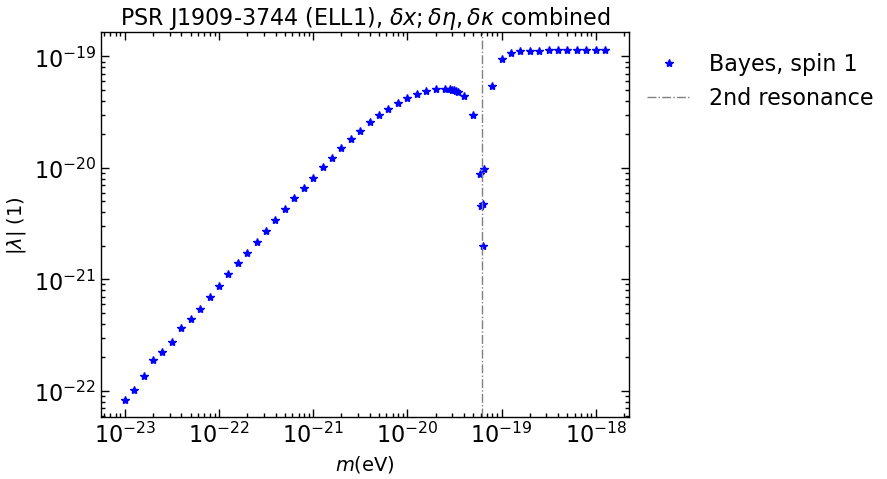

In [116]:
# ULDM amplitude, phase
r_ex = 1
upsasc_ex = np.pi/4

# for spin 1
phi_ex = np.pi/4
theta_ex = np.pi/4

# considered mass interval
mass_list = list(10**np.arange(-23,-17.9,0.1)) + [0.9 * omega_b_ev.value, 0.95 * omega_b_ev.value, 1.05 * omega_b_ev.value, 1.1 * omega_b_ev.value]  + [1.9 * omega_b_ev.value, 1.95 * omega_b_ev.value, 2.05 * omega_b_ev.value, 2.1 * omega_b_ev.value]
sorted(mass_list)
mass_array = np.array(mass_list) * u.eV

# lambda values
lamb_sensitivity_s1 = np.array([lambda_s1(x, m, r_ex, omega_b_ev, upsasc_ex, theta_ex, phi_ex) for m in mass_array])

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(15, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m$(eV)', fontsize=14)
plt.ylabel(r'$|\lambda|$ (1)', fontsize=14)
plt.plot(mass_array, lamb_sensitivity_s1, "*", label="Bayes, spin 1", color = "blue")
plt.axvline(x = 2 * omega_b_ev.value, color='grey', linestyle='-.', linewidth=1, label= "2nd resonance")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.title(psr_name + r", $\delta x; \delta \eta, \delta \kappa$ combined")

### 3.5 Spin-2 signal modelling

\begin{align}
    T_k^a(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega) = & +\frac{\epsilon_T}{2}\left( \frac{1}{k} - 1 \right) \frac{\cos(\Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^2) - \cos\left[(k-2)\Psi' + \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^2\right]}{k-2} \nonumber \nonumber \\
    & -\frac{\epsilon_T}{2}\left( \frac{1}{k} + 1 \right) \frac{\cos(\Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^2) - \cos\left[(k+2)\Psi' + \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^2\right]}{k+2} \nonumber \\
    & -\frac{\epsilon_S}{\sqrt{3}} \frac{\cos \Upsilon_{\mathrm{asc}} - \cos\left( k \Psi' + \Upsilon_{\mathrm{asc}} \right)}{k}\,.
\end{align}

In [119]:
def T_a(k, psi, upsilon, chi, omega, eps_s, eps_t):
    
    chi2 = chi + 2 * omega
    
    numer1 = np.cos(upsilon + chi2) - np.cos((k-2)*psi + upsilon + chi2)
    denom1 = k - 2
    term1  = eps_t / 2 * (1/k - 1) * numer1 / denom1

    numer2 = np.cos(upsilon - chi2) - np.cos((k+2)*psi + upsilon - chi2)
    denom2 = k + 2
    term2  = - eps_t / 2 * (1/k + 1) * numer2 / denom2

    numer3 = np.cos(upsilon) - np.cos(k*psi + upsilon)
    denom3 = k
    term3  = - eps_s / np.sqrt(3) * numer3 / denom3

    result = term1 + term2 + term3

    return result

\begin{align}
 T_k^\omega(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega) = & -\epsilon_T\left(\frac{1}{k} + 1 \right) \frac{ \sin\left[(k+1) \Psi' + \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^1\right] - \sin(\Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^1)  }{ k + 1 } \nonumber \\
 & -\epsilon_T\left(\frac{1}{k} - 1 \right) \frac{ \sin\left[(k-1) \Psi' + \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^1\right] - \sin(\Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^1)  }{ k - 1 } \nonumber \\
 & + \frac{1}{\sqrt{3}} \epsilon_S \left(\frac{1}{2}\frac{1}{k} + 1\right) \frac{ \sin\left[ (k+1)\Psi' + \Upsilon_{\mathrm{asc}} - \omega \right] - \sin(\Upsilon_{\mathrm{asc}} - \omega) }{ k + 1} \nonumber \\
 & + \frac{1}{\sqrt{3}} \epsilon_S \left(\frac{1}{2}\frac{1}{k} - 1\right) \frac{ \sin\left[ (k-1)\Psi' + \Upsilon_{\mathrm{asc}} + \omega \right] - \sin(\Upsilon_{\mathrm{asc}} + \omega) }{ k - 1}\,. 
\end{align}

In [121]:
def T_omega(k, psi, upsilon, chi, omega, eps_s, eps_t):
    
    chi1 = chi + omega
    
    numer1 = np.sin((k+1)*psi + upsilon - chi1) - np.sin(upsilon - chi1)
    denom1 = k + 1
    term1  = - eps_t * (1/k + 1) * numer1 / denom1

    numer2 = np.sin((k-1)*psi + upsilon + chi1) - np.sin(upsilon + chi1)
    denom2 = k - 1
    term2  = - eps_t * (1/k - 1) * numer2 / denom2

    numer3 = np.sin((k+1)*psi + upsilon - omega) - np.sin(upsilon - omega)
    denom3 = k + 1
    term3  = eps_s / np.sqrt(3) * (0.5/k + 1) * numer3 / denom3

    numer4 = np.sin((k-1)*psi + upsilon + omega) - np.sin(upsilon + omega)
    denom4 = k - 1
    term4  = eps_s / np.sqrt(3) * (0.5/k - 1) * numer4 / denom4

    result = term1 + term2 + term3 + term4

    return result

\begin{align}
    T_k^e(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega) = & -\frac{3}{4} \frac{1}{k} \epsilon_T \frac{\cos(\Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^1) - \cos\left[(k+1)\Psi' + \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^1\right]}{k+1} \nonumber \\
    & +\frac{3}{4} \frac{1}{k} \epsilon_T \frac{\cos(\Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^1) - \cos\left[(k-1)\Psi' + \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^1\right]}{k-1} \nonumber \\
    & - \left[ \frac{1}{\sqrt{3}} \left( \frac{1}{2}\frac{1}{k} + 1 \right) \epsilon_S + \frac{1}{4}\epsilon_T \right] \frac{\cos\left(\Upsilon_{\mathrm{asc}} - \omega\right) - \cos\left[(k+1)\Psi' + \Upsilon_{\mathrm{asc}} - \omega\right]}{k+1} \nonumber \\
    & + \left[ \frac{1}{\sqrt{3}} \left( \frac{1}{2}\frac{1}{k} - 1 \right) \epsilon_S - \frac{1}{4}\epsilon_T \right] \frac{\cos\left(\Upsilon_{\mathrm{asc}} + \omega\right) - \cos\left[(k-1)\Psi' + \Upsilon_{\mathrm{asc}} + \omega\right]}{k-1} \nonumber \\
     & - \frac{1}{2}\epsilon_T  \frac{\cos\left( \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^2\right) - \cos\left[(k+2)\Psi' + \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^2\right]}{k+2} \nonumber \\
     & - \frac{1}{2}\epsilon_T  \frac{\cos\left( \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^2\right) - \cos\left[(k-2)\Psi' + \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^2\right]}{k-2} \nonumber \\
     & - \frac{1}{4}\epsilon_T \frac{1}{k} \frac{\cos\left( \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^3\right) - \cos\left[(k+3)\Psi' + \Upsilon_{\mathrm{asc}} - \chi_{\mathrm{asc}}^3\right]}{k+3} \nonumber \\
     & + \frac{1}{4}\epsilon_T \frac{1}{k} \frac{\cos\left( \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^3\right) - \cos\left[(k-3)\Psi' + \Upsilon_{\mathrm{asc}} + \chi_{\mathrm{asc}}^3\right]}{k-3} \nonumber \\
      & - \frac{1}{4}\epsilon_T \frac{\cos\left( \Upsilon_{\mathrm{asc}} - 3\omega\right) - \cos\left[(k+3)\Psi' + \Upsilon_{\mathrm{asc}} - 3\omega\right]}{k+3} \nonumber \\
      & - \frac{1}{4}\epsilon_T \frac{\cos\left( \Upsilon_{\mathrm{asc}} + 3\omega\right) - \cos\left[(k-3)\Psi' + \Upsilon_{\mathrm{asc}} + 3\omega\right]}{k-3} \,.
\end{align}

In [123]:
def T_e(k, psi, upsilon, chi, omega, eps_s, eps_t):
    
    chi1 = chi + omega
    chi2 = chi + 2 * omega
    chi3 = chi + 3 * omega

    numer1 = np.cos(upsilon - chi1) - np.cos((k+1)*psi + upsilon - chi1)
    denom1 = k + 1
    term1  = -3/4 / k * eps_t * numer1 / denom1

    numer2 = np.cos(upsilon + chi1) - np.cos((k-1)*psi + upsilon + chi1)
    denom2 = k - 1
    term2  = 3/4 / k * eps_t * numer2 / denom2
    
    numer3 = np.cos(upsilon - omega) - np.cos((k+1)*psi + upsilon - omega)
    denom3 = k + 1
    term3  = - ( 1 / np.sqrt(3) * (0.5/k + 1) * eps_s + 1/4 * eps_t) * numer3 / denom3

    numer4 = np.cos(upsilon + omega) - np.cos((k-1)*psi + upsilon + omega)
    denom4 = k - 1
    term4  = ( 1 / np.sqrt(3) * (0.5/k - 1) * eps_s - 1/4 * eps_t) * numer4 / denom4

    numer5 = np.cos(upsilon - chi2) - np.cos((k+2)*psi + upsilon - chi2)
    denom5 = k + 2
    term5 = - 0.5 * eps_t * numer5 / denom5

    numer6 = np.cos(upsilon + chi2) - np.cos((k-2)*psi + upsilon + chi2)
    denom6 = k - 2
    term6 = - 0.5 * eps_t * numer6 / denom6

    numer7 = np.cos(upsilon - chi3) - np.cos((k+3)*psi + upsilon - chi3)
    denom7 = k + 3
    term7 = - 0.25 * eps_t / k * numer7 / denom7

    numer8 = np.cos(upsilon + chi3) - np.cos((k-3)*psi + upsilon + chi3)
    denom8 = k - 3
    term8 = 0.25 * eps_t / k * numer8 / denom8

    numer9 = np.cos(upsilon - 3 * omega) - np.cos((k+3)*psi + upsilon - 3 * omega)
    denom9 = k + 3
    term9 = - 0.25 * eps_t * numer9 / denom9

    numer10 = np.cos(upsilon + 3 * omega) - np.cos((k-3)*psi + upsilon + 3 * omega)
    denom10 = k - 3
    term10 = - 0.25 * eps_t * numer10 / denom10

    result = term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10

    return result

\begin{align*}
    \frac{\lambda \sqrt{2 \rho_\mathrm{DM}}}{\omega_b} = 8.77\times10^{-20} \Lambda \sqrt{\frac{\rho_{\mathrm{DM}}}{\frac{\mathrm{GeV}}{\mathrm{cm}^3}}} \left(\frac{\omega_b}{\mathrm{s}^{-1}}\right)^{-1}\,, 
\end{align*}

In [125]:
def factor_spin_2(lamb):
    result = lamb * 8.77e-12 * np.sqrt(rhoDM.value) / omega_b.value
    return result

\begin{align}
    \delta x &= 4 \frac{\lambda \sqrt{2 \rho_\mathrm{DM}}}{\omega_b} x \varrho T_k^a(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega)\,, \\
\end{align}

In [127]:
def delta_x_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    result = 4 * factor_spin_2(lamb) * x * rho * T_a(k, psi, upsilon, chi, omega, eps_s, eps_t)
    
    return result

\begin{align}
    \delta e &= 2 \frac{\lambda \sqrt{2 \rho_\mathrm{DM}}}{\omega_b}  \varrho T_k^e(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega)\,, \\
\end{align}

In [129]:
def delta_e_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    result = 2 * factor_spin_2(lamb) * rho * T_e(k, psi, upsilon, chi, omega, eps_s, eps_t)
    
    return result

\begin{align}
    e \delta \omega &= 2 \frac{\lambda \sqrt{2 \rho_\mathrm{DM}}}{\omega_b}  \varrho T_k^\omega(\Psi', \Upsilon_{\mathrm{asc}}, \chi, \omega)\,, 
\end{align}

In [131]:
def delta_eomega_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):

    m_value = m.to(u.eV).value
    omega_b_ev_value = omega_b_ev.to(u.eV).value
    k = m_value / omega_b_ev_value
    
    result = 2 * factor_spin_2(lamb) * rho * T_omega(k, psi, upsilon, chi, omega, eps_s, eps_t)
    
    return result

$$
\delta \eta = (\delta e) \sin \omega + (e \delta \omega) \cos \omega\,,\,\, \delta \kappa = (\delta e) \cos \omega - (e \delta \omega) \sin \omega\,,
$$

In [133]:
def delta_eta_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):
    
    term1 = delta_e_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)      * np.sin(omega)
    term2 = delta_eomega_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega) * np.cos(omega)

    return term1 + term2

def delta_kappa_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):
    
    term1 = delta_e_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)      * np.cos(omega)
    term2 = delta_eomega_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega) * np.sin(omega)

    return term1 - term2

\begin{equation}
R_i^{\mathrm{binary}} = \sin (\Psi'_i) \delta x_i - x\frac{\cos(2\Psi'_i) + 3}{2} \delta \eta_i +  x\frac{\sin(2\Psi'_i)}{2} \delta \kappa_i\,,
\end{equation}

In [135]:
def residuum_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega):
    
    x_contribution     = np.sin(psi) * delta_x_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)
    eta_contribution   = - x * (np.cos(2*psi) + 3) / 2 * delta_eta_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)
    kappa_contribution = x * np.sin(2*psi) / 2 * delta_kappa_s2(lamb, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)
        
    return x_contribution + eta_contribution + kappa_contribution

Bayesian line

In [137]:
def lambda_s2(m, rho, upsilon, chi, eps_s, eps_t):
  psi = np.array(psi_i(omega_b, Tasc, TOA_sim_array))
  Q_vector = residuum_s2(1, m, rho, upsilon, chi, eps_s, eps_t, omega_b_ev, psi, omega)
  Q_array = np.array(Q_vector) * u.s
  Q_length = np.sqrt( np.dot(Q_array,Q_array) )

  result = np.sqrt(np.log(1000)) * noise / Q_length

  return result

Text(0.5, 1.0, 'PSR J1909-3744 (ELL1), $\\delta x; \\delta \\eta, \\delta \\kappa$ combined')

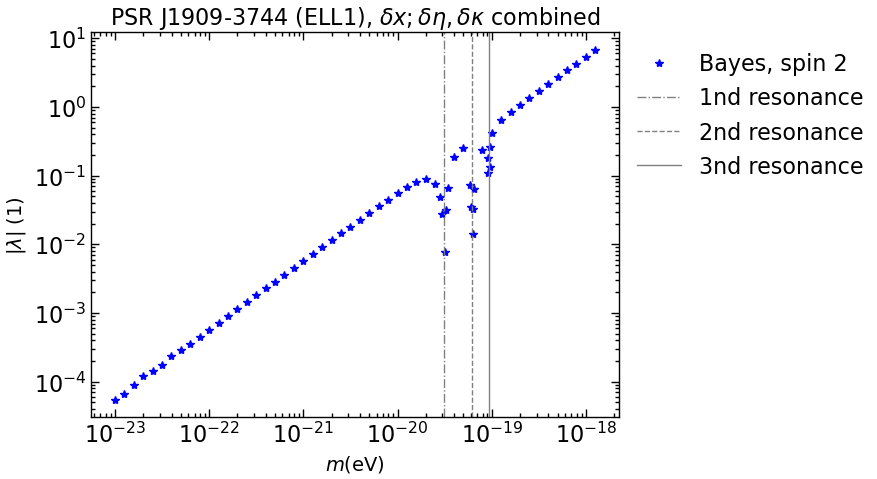

In [138]:
# ULDM amplitude, phase
r_ex = 1
upsasc_ex = np.pi/4

# for spin 1
phi_ex = np.pi/4
theta_ex = np.pi/4

# for spin 2
chi_ex, eps_s_ex, eps_t_ex = np.pi/4, 0.707, 0.707

# considered mass interval
mass_list = list(10**np.arange(-23,-17.9,0.1)) + [0.9 * omega_b_ev.value, 0.95 * omega_b_ev.value, 1.05 * omega_b_ev.value, 1.1 * omega_b_ev.value]  + [1.9 * omega_b_ev.value, 1.95 * omega_b_ev.value, 2.05 * omega_b_ev.value, 2.1 * omega_b_ev.value] + [2.9 * omega_b_ev.value, 2.95 * omega_b_ev.value, 3.05 * omega_b_ev.value, 3.1 * omega_b_ev.value]
sorted(mass_list)
mass_array = np.array(mass_list) * u.eV

# lambda values
lamb_sensitivity_s2 = np.array([lambda_s2(m, r_ex, upsasc_ex, chi_ex, eps_s_ex, eps_t_ex) for m in mass_array])

# Create a figure with 1 row and 2 columns
plt.figure(figsize=(15, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$m$(eV)', fontsize=14)
plt.ylabel(r'$|\lambda|$ (1)', fontsize=14)
plt.plot(mass_array, lamb_sensitivity_s2, "*", label="Bayes, spin 2", color = "blue")
plt.axvline(x = 1 * omega_b_ev.value, color='grey', linestyle='-.', linewidth=1, label= "1nd resonance")
plt.axvline(x = 2 * omega_b_ev.value, color='grey', linestyle='--', linewidth=1, label= "2nd resonance")
plt.axvline(x = 3 * omega_b_ev.value, color='grey', linestyle='-', linewidth=1, label= "3nd resonance")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.title(psr_name + r", $\delta x; \delta \eta, \delta \kappa$ combined")

# 4. Data generation

Mock data generation

### 4.1 Function for mock data generation (1 instance)

In [142]:
def one_run_signal_with_noise_SNR_fixed(model, m, dm_parameters_list, snr, K0, K1, K2, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kap0, Anp_kap1, noise_model):

    m_val = m.to(u.eV).value
    omegb_ev_val = omega_b_ev.value
    k = m_val / omegb_ev_val
    psi =  np.array(psi_i(omega_b, Tasc, TOA_sim_array))

    # ULDM signal, stripped of the lambda * rho
    if model == "s0l":
                                                                 # upsilon
        q_vec = residuum_s0l(1, x, m, rhoDM, 1, omega_b_ev, psi, dm_parameters_list[0])
    if model == "s0q":
                                                                 # upsilon
        q_vec = residuum_s0q(1, x, m, rhoDM, 1, omega_b_ev, psi, dm_parameters_list[0])
    if model == "s1":
                                                         # upsilonasc, theta, phi
        q_vec = residuum_s1(1, x, m, 1, omega_b_ev, psi, dm_parameters_list[0], dm_parameters_list[1], dm_parameters_list[2])
    if model == "s2":
                                               # upsilon, chi, eps_s, eps_t
        q_vec = residuum_s2(1, m, 1, dm_parameters_list[0], dm_parameters_list[1], dm_parameters_list[2], dm_parameters_list[3], omega_b_ev, psi, omega)
    
    q_vec = np.array(q_vec)
    q_len = np.sqrt( np.dot(q_vec,q_vec) )

    # compute the amplitude A, so the SNR equals to the given number snr
    amp = snr * noise.to(u.s).value / q_len    

    # ULDM signal with given frequency/mass and SNR
    signalDM = np.array(amp * q_vec)

    # signal from K0 (unit of time)
    signal_K0 = np.array( K0 * np.ones(len(TOA_sim_array)) )

    # time vector
    tminTasc = np.array(TOA_sim_array.to(u.s)) - np.array(Tasc.to(u.s))
    
    # signal from K1 (unit of 1)
    signal_K1 = K1 * tminTasc

    # signal from K2 (unit of 1/time)
    signal_K2 = K2 * tminTasc**2

    # nuis. param. for x 
    signal_Anp_x0 = np.array( Anp_x0 * cx_i(TOA_sim_array) )   # dim Anp_x0 = s 
    signal_Anp_x1 = np.array( Anp_x1 * lx_i(TOA_sim_array) )   # dim Anp_x0 = 1 

    # nuis. param. for eta 
    signal_Anp_eta0 = np.array( Anp_eta0 * ceta_i(TOA_sim_array) )  # dim Anp_eta0 = 1
    signal_Anp_eta1 = np.array( Anp_eta1 * leta_i(TOA_sim_array) )  # dim Anp_eta1 = 1 / s

    # nuis. param. for kappa 
    signal_Anp_kap0 = np.array( Anp_kap0 * ckappa_i(TOA_sim_array) )  # dim Anp_eta0 = 1
    signal_Anp_kap1 = np.array( Anp_kap1 * lkappa_i(TOA_sim_array) )  # dim Anp_eta1 = 1 / s

    # gauss noise (unit of time)
    if noise_model == "white":
        gauss_noise =  white_gauss_noise_gen()
    if noise_model == "red":
        gauss_noise = red_gauss_noise_gen()
    if noise_model == "combined":
        gauss_noise = combined_noise_gen()

    # time residuals - sum of all signals
    res = signalDM + signal_K0 + signal_K1 + signal_K2 + signal_Anp_x0 + signal_Anp_x1 + signal_Anp_eta0 + signal_Anp_eta1 + signal_Anp_kap0 + signal_Anp_kap1 + gauss_noise
    
    return res, signalDM, signal_K0, signal_K1, signal_K2, signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise

We rescale time series so the standard deviation of the total signal matches the std we know.

In [144]:
#def one_run_signal_with_noise_SNR_fixed_norm(model, m, dm_parameters_list, snr, K0, K1, K2, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kap0, Anp_kap1, noise_model):
#
#    res, signalDM, signal_K0, signal_K1, signal_K2, signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise = one_run_signal_with_noise_SNR_fixed(model, m, dm_parameters_list, snr, K0, K1, K2, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kap0, Anp_kap1, noise_model)
#
#    std_dev_res = st.stdev(res)
#
#    ft = noise.value / std_dev_res
#    
#    return ft * res, ft * signalDM, ft * signal_K0, ft * signal_K1, ft * signal_K2, ft * signal_Anp_x0, ft * signal_Anp_x1, ft * signal_Anp_eta0, ft * signal_Anp_eta1, ft * signal_Anp_kap0, ft * signal_Anp_kap1, ft * gauss_noise

Example: spin 0, linear

In [146]:
m_ex      = 1e-20 * u.eV
upsasc_ex = np.pi/4
snr_ex    = 20

f = 1
K0_ex     = f * noise.to(u.s).value
K1_ex     = (f * noise.to(u.s) / (Tmax - Tmin).to(u.s)).value
K2_ex     = (f * noise.to(u.s) / ((Tmax - Tmin).to(u.s))**2).value
Anp_x0   = f * noise.to(u.s).value
Anp_x1   = (f * noise.to(u.s) / (Tmax - Tmin).to(u.s)).value
Anp_eta0 = (f * noise.to(u.s) / x.to(u.s)).value
Anp_eta1 = (f * noise.to(u.s) / x.to(u.s) / (Tmax - Tmin).to(u.s)).value
Anp_kappa0 = (f * noise.to(u.s) / x.to(u.s)).value
Anp_kappa1 = (f * noise.to(u.s) / x.to(u.s) / (Tmax - Tmin).to(u.s)).value

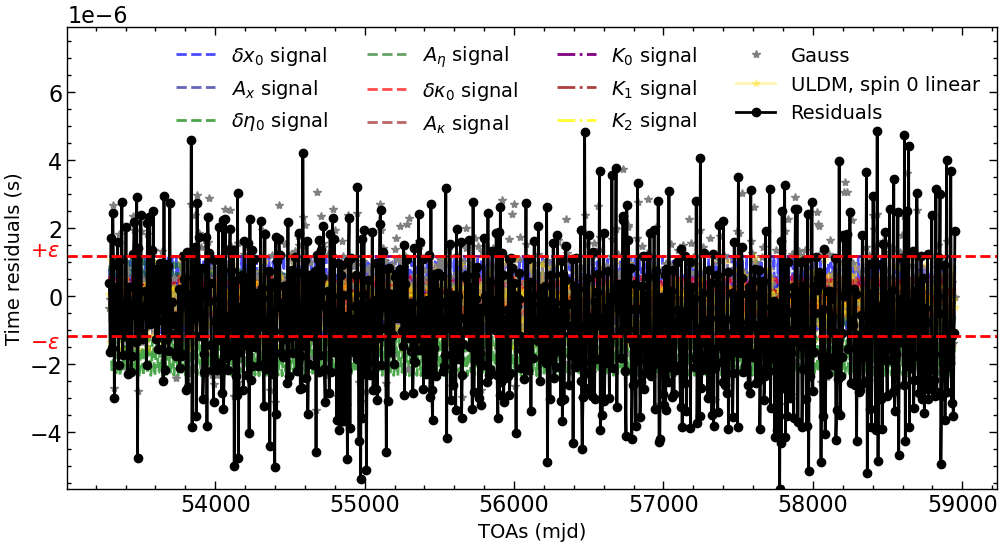

In [147]:
# spin 0, linear ULDM, white Gaussian noise, nuisance parameters included

res, signalDM_s0l, signal_K0, signal_K1, signal_K2,  signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise = one_run_signal_with_noise_SNR_fixed("s0l", m_ex, [upsasc_ex], snr_ex, K0_ex, K1_ex, K2_ex, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kappa0, Anp_kappa1, "white")

plt.figure(figsize=(12, 6))

# figure 1
plt.plot(TOA_sim_array, signal_Anp_x0, "--",   color = "blue",      label = r"$\delta x_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_x1, "--",   color = "darkblue",  label = r"$A_x$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_eta0, "--", color = "green",     label = r"$\delta \eta_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_eta1, "--", color = "darkgreen", label = r"$A_\eta$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_kap0, "--", color = "red",       label = r"$\delta \kappa_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_kap1, "--", color = "darkred",   label = r"$A_\kappa$ signal", alpha = 0.6)

# figure 2
plt.plot(TOA_sim_array, signal_K0, "-.", color = "purple", label = r"$K_0$ signal", alpha = 1)
plt.plot(TOA_sim_array, signal_K1, "-.", color = "brown", label = r"$K_1$ signal", alpha = 0.9)
plt.plot(TOA_sim_array, signal_K2, "-.", color = "yellow", label = r"$K_2$ signal", alpha = 0.8)

# figure 3
plt.plot(TOA_sim_array, gauss_noise, "*",   color = "grey", label = "Gauss", alpha = 1)
plt.plot(TOA_sim_array, signalDM_s0l, "*-", color = "gold", label = "ULDM, spin 0 linear", alpha = 0.3)
plt.plot(TOA_sim_array, res, "o-", color = "black", label = "Residuals", alpha = 1)

plt.axhline(y=noise.value, color='r', linestyle='--')
plt.axhline(y=-noise.value, color='r', linestyle='--')

plt.xlabel('TOAs (mjd)', fontsize=14)
plt.ylabel('Time residuals (s)', fontsize=14)
plt.ylim(-max(abs(res)), 1.4 * max(abs(res)))

plt.text(TOA_sim_array[0].value * 0.99, noise.value, r'$+\epsilon$', style ='italic', fontsize = 15, color ="red")
plt.text(TOA_sim_array[0].value * 0.99, -1.3*noise.value, r'$-\epsilon$', style ='italic', fontsize = 15, color ="red")

plt.legend(ncol=4, fontsize = 14, loc = "upper right")

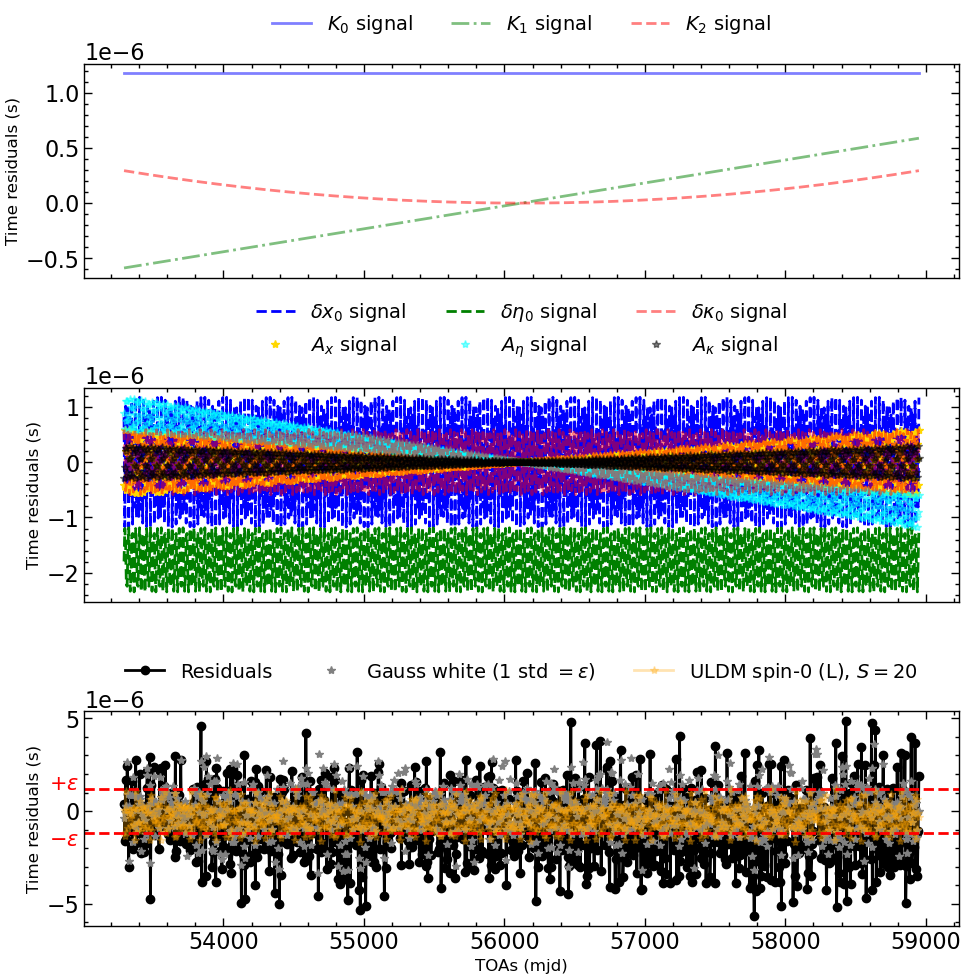

In [148]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Figure 1
axs[0].plot(TOA_sim_array, signal_K0, "-", color="blue", label=r"$K_0$ signal", alpha=0.5)
axs[0].plot(TOA_sim_array, signal_K1, "-.", color="green", label=r"$K_1$ signal", alpha=0.5)
axs[0].plot(TOA_sim_array, signal_K2, "--", color="red", label=r"$K_2$ signal", alpha=0.5)


axs[1].plot(TOA_sim_array, signal_Anp_x0, "--", color="blue", label=r"$\delta x_0$ signal", alpha=1)
axs[1].plot(TOA_sim_array, signal_Anp_x1, "*", color="gold", label=r"$A_x$ signal", alpha=1)
axs[1].plot(TOA_sim_array, signal_Anp_eta0, "--", color="green", label=r"$\delta \eta_0$ signal", alpha=1)
axs[1].plot(TOA_sim_array, signal_Anp_eta1, "*", color="cyan", label=r"$A_\eta$ signal", alpha=0.5)
axs[1].plot(TOA_sim_array, signal_Anp_kap0, "--", color="red", label=r"$\delta \kappa_0$ signal", alpha=0.5)
axs[1].plot(TOA_sim_array, signal_Anp_kap1, "*", color="black", label=r"$A_\kappa$ signal", alpha=0.5)


# Figure 2
axs[2].plot(TOA_sim_array, res, "o-", color="black", label="Residuals", alpha=1)
axs[2].plot(TOA_sim_array, gauss_noise, "*", color="grey", label= r"Gauss white (1 std $ = \epsilon$)", alpha=1)
axs[2].plot(TOA_sim_array, signalDM_s0l, "*-", color="orange", label = r"ULDM spin-0 (L), $S = 20$", alpha=0.3)

# Add horizontal lines for noise in the last subplot
axs[2].axhline(y=noise.value, color='r', linestyle='--')
axs[2].axhline(y=-noise.value, color='r', linestyle='--')

axs[2].text(TOA_sim_array[0].value * 0.99, noise.value, r'$+\epsilon$', style ='italic', fontsize = 15, color ="red")
axs[2].text(TOA_sim_array[0].value * 0.99, -1.6*noise.value, r'$-\epsilon$', style ='italic', fontsize = 15, color ="red")

# Set labels and legends
for ax in axs:
    ax.set_ylabel('Time residuals (s)', fontsize=12)
    ax.legend(ncol=3, fontsize=14, loc = "lower center", bbox_to_anchor=(0.5, 1.05))

# Set the x-axis label only on the last subplot
axs[2].set_xlabel('TOAs (mjd)', fontsize=12)

# Show the plot
plt.tight_layout()

plt.savefig("store/plots/time_residuals_example.png")

plt.show()

Example: spin 0, quadratic

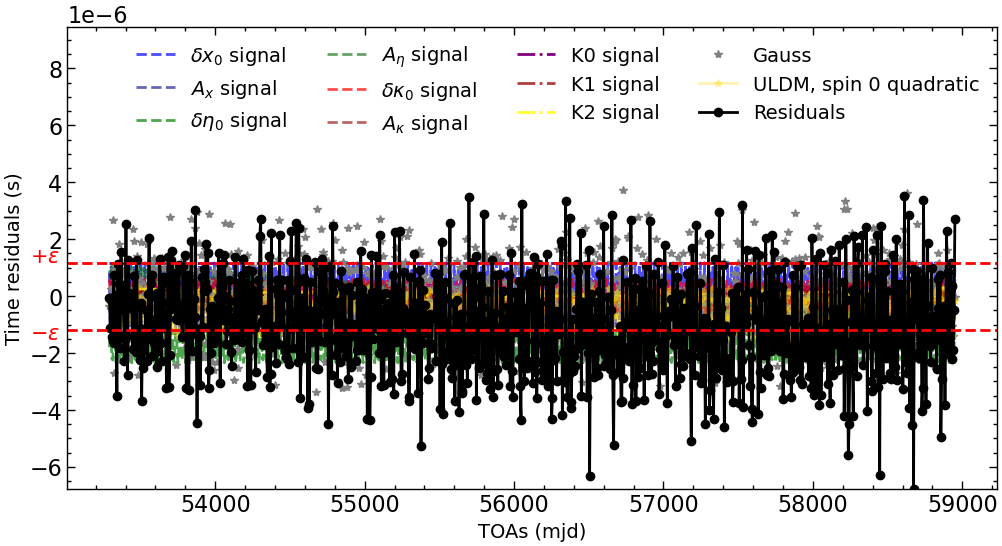

In [150]:
# spin 0, quadratic ULDM, white Gaussian noise, nuisance parameters included

res, signalDM_s0q, signal_K0, signal_K1, signal_K2,  signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise_ex = one_run_signal_with_noise_SNR_fixed("s0q", m_ex, [upsasc_ex], snr_ex, K0_ex, K1_ex, K2_ex, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kappa0, Anp_kappa1, "white")

plt.figure(figsize=(12, 6))

# figure 1
plt.plot(TOA_sim_array, signal_Anp_x0, "--",   color = "blue",      label = r"$\delta x_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_x1, "--",   color = "darkblue",  label = r"$A_x$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_eta0, "--", color = "green",     label = r"$\delta \eta_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_eta1, "--", color = "darkgreen", label = r"$A_\eta$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_kap0, "--", color = "red",       label = r"$\delta \kappa_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_kap1, "--", color = "darkred",   label = r"$A_\kappa$ signal", alpha = 0.6)

# figure 2
plt.plot(TOA_sim_array, signal_K0, "-.", color = "purple", label = "K0 signal", alpha = 1)
plt.plot(TOA_sim_array, signal_K1, "-.", color = "brown", label = "K1 signal", alpha = 0.9)
plt.plot(TOA_sim_array, signal_K2, "-.", color = "yellow", label = "K2 signal", alpha = 0.8)

# figure 3
plt.plot(TOA_sim_array, gauss_noise, "*",   color = "grey", label = "Gauss", alpha = 1)
plt.plot(TOA_sim_array, signalDM_s0q, "*-", color = "gold", label = "ULDM, spin 0 quadratic", alpha = 0.3)
plt.plot(TOA_sim_array, res, "o-", color = "black", label = "Residuals", alpha = 1)

plt.axhline(y=noise.value, color='r', linestyle='--')
plt.axhline(y=-noise.value, color='r', linestyle='--')

plt.xlabel('TOAs (mjd)', fontsize=14)
plt.ylabel('Time residuals (s)', fontsize=14)
plt.ylim(-max(abs(res)), 1.4 * max(abs(res)))

plt.text(TOA_sim_array[0].value * 0.99, noise.value, r'$+\epsilon$', style ='italic', fontsize = 15, color ="red")
plt.text(TOA_sim_array[0].value * 0.99, -1.3*noise.value, r'$-\epsilon$', style ='italic', fontsize = 15, color ="red")

plt.legend(ncol=4, fontsize = 14, loc = "upper right")

Example: spin 1

In [152]:
phi_ex    = np.pi/4
theta_ex  = np.pi/4

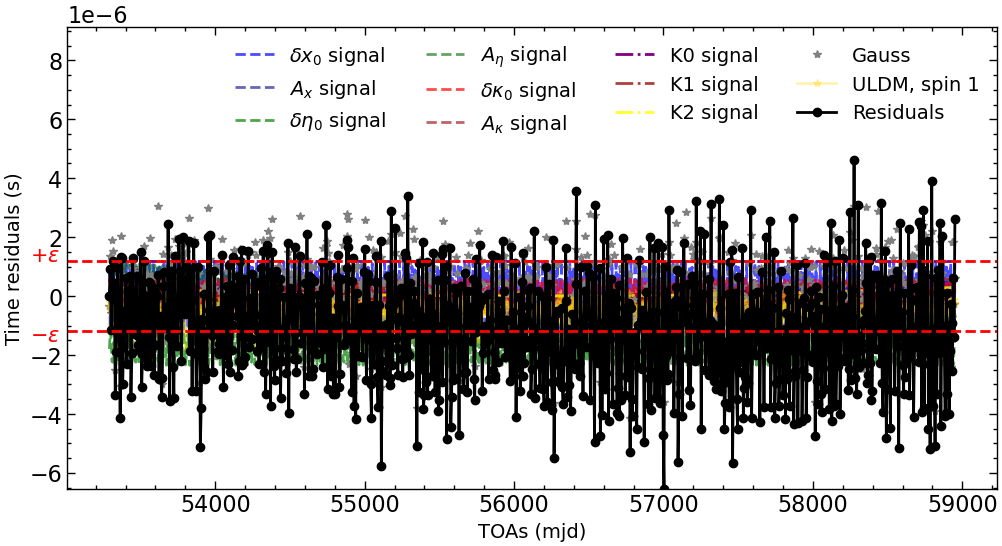

In [153]:
# spin 1, white Gaussian noise, nuisance parameters included

res, signalDM_s1, signal_K0, signal_K1, signal_K2,  signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise = one_run_signal_with_noise_SNR_fixed("s1", m_ex, [upsasc_ex, phi_ex, theta_ex], snr_ex, K0_ex, K1_ex, K2_ex, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kappa0, Anp_kappa1, "white")

plt.figure(figsize=(12, 6))

# figure 1
plt.plot(TOA_sim_array, signal_Anp_x0, "--",   color = "blue",      label = r"$\delta x_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_x1, "--",   color = "darkblue",  label = r"$A_x$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_eta0, "--", color = "green",     label = r"$\delta \eta_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_eta1, "--", color = "darkgreen", label = r"$A_\eta$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_kap0, "--", color = "red",       label = r"$\delta \kappa_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_kap1, "--", color = "darkred",   label = r"$A_\kappa$ signal", alpha = 0.6)

# figure 2
plt.plot(TOA_sim_array, signal_K0, "-.", color = "purple", label = "K0 signal", alpha = 1)
plt.plot(TOA_sim_array, signal_K1, "-.", color = "brown", label = "K1 signal", alpha = 0.9)
plt.plot(TOA_sim_array, signal_K2, "-.", color = "yellow", label = "K2 signal", alpha = 0.8)

# figure 3
plt.plot(TOA_sim_array, gauss_noise, "*",   color = "grey", label = "Gauss", alpha = 1)
plt.plot(TOA_sim_array, signalDM_s1, "*-", color = "gold", label = "ULDM, spin 1", alpha = 0.3)
plt.plot(TOA_sim_array, res, "o-", color = "black", label = "Residuals", alpha = 1)

plt.axhline(y=noise.value, color='r', linestyle='--')
plt.axhline(y=-noise.value, color='r', linestyle='--')

plt.xlabel('TOAs (mjd)', fontsize=14)
plt.ylabel('Time residuals (s)', fontsize=14)
plt.ylim(-max(abs(res)), 1.4 * max(abs(res)))

plt.text(TOA_sim_array[0].value * 0.99, noise.value, r'$+\epsilon$', style ='italic', fontsize = 15, color ="red")
plt.text(TOA_sim_array[0].value * 0.99, -1.3*noise.value, r'$-\epsilon$', style ='italic', fontsize = 15, color ="red")

plt.legend(ncol=4, fontsize = 14, loc = "upper right")

Example: spin 2

In [155]:
upsilon_ex, chi_ex, eps_s_ex, eps_t_ex = np.pi/4, np.pi/4, 1/np.sqrt(2), 1/np.sqrt(2)

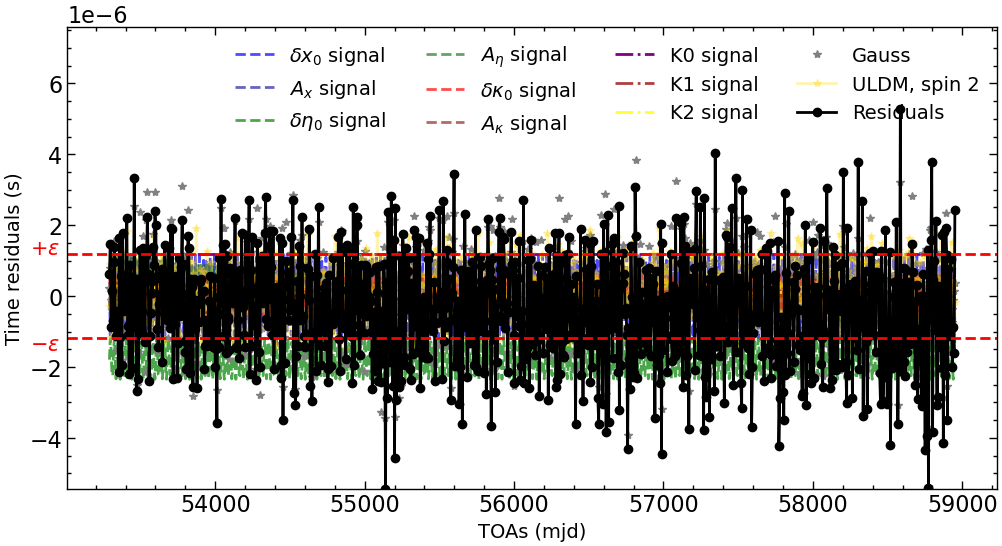

In [156]:
# spin 2, white Gaussian noise, nuisance parameters included

res, signalDM_s2, signal_K0, signal_K1, signal_K2,  signal_Anp_x0, signal_Anp_x1, signal_Anp_eta0, signal_Anp_eta1, signal_Anp_kap0, signal_Anp_kap1, gauss_noise = one_run_signal_with_noise_SNR_fixed("s2", m_ex, [upsilon_ex, chi_ex, eps_s_ex, eps_t_ex], snr_ex, K0_ex, K1_ex, K2_ex, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kappa0, Anp_kappa1, "white")

plt.figure(figsize=(12, 6))

# figure 1
plt.plot(TOA_sim_array, signal_Anp_x0, "--",   color = "blue",      label = r"$\delta x_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_x1, "--",   color = "darkblue",  label = r"$A_x$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_eta0, "--", color = "green",     label = r"$\delta \eta_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_eta1, "--", color = "darkgreen", label = r"$A_\eta$ signal", alpha = 0.6)
plt.plot(TOA_sim_array, signal_Anp_kap0, "--", color = "red",       label = r"$\delta \kappa_0$ signal", alpha = 0.7)
plt.plot(TOA_sim_array, signal_Anp_kap1, "--", color = "darkred",   label = r"$A_\kappa$ signal", alpha = 0.6)

# figure 2
plt.plot(TOA_sim_array, signal_K0, "-.", color = "purple", label = "K0 signal", alpha = 1)
plt.plot(TOA_sim_array, signal_K1, "-.", color = "brown", label = "K1 signal", alpha = 0.9)
plt.plot(TOA_sim_array, signal_K2, "-.", color = "yellow", label = "K2 signal", alpha = 0.8)

# figure 3
plt.plot(TOA_sim_array, gauss_noise, "*",   color = "grey", label = "Gauss", alpha = 1)
plt.plot(TOA_sim_array, signalDM_s2, "*-", color = "gold", label = "ULDM, spin 2", alpha = 0.3)
plt.plot(TOA_sim_array, res, "o-", color = "black", label = "Residuals", alpha = 1)

plt.axhline(y=noise.value, color='r', linestyle='--')
plt.axhline(y=-noise.value, color='r', linestyle='--')

plt.xlabel('TOAs (mjd)', fontsize=14)
plt.ylabel('Time residuals (s)', fontsize=14)
plt.ylim(-max(abs(res)), 1.4 * max(abs(res)))

plt.text(TOA_sim_array[0].value * 0.99, noise.value, r'$+\epsilon$', style ='italic', fontsize = 15, color ="red")
plt.text(TOA_sim_array[0].value * 0.99, -1.3*noise.value, r'$-\epsilon$', style ='italic', fontsize = 15, color ="red")

plt.legend(ncol=4, fontsize = 14, loc = "upper right")

### 4.2 Function for mock data generation (N instances)

Generation of $N$ noisy time series with given SNR

In [264]:
def Nruns_noisydata_SNR_fixed(N, m_list, snr, spin, noise_model, nuis_control):

    res_array = []
    
    for _ in range(N):

        # random sampling of frequency/mass in the given mass range
        m_min_val = m_list[0].to(u.eV).value
        m_max_val = m_list[1].to(u.eV).value
        m = rd.uniform(m_min_val,m_max_val) * u.eV

        # factor controlling amplitudes of all signals, excluding ULDM signal and Gaussian noise
        f = nuis_control
        K0 = rd.uniform(-1,1) * f * noise.to(u.s).value
        K1 = rd.uniform(-1,1) * (f * noise.to(u.s) / (Tmax - Tmin).to(u.s)).value
        K2 = rd.uniform(-1,1) * (f * noise.to(u.s) / ((Tmax - Tmin).to(u.s))**2).value
        Anp_x0 = rd.uniform(-1,1) * f * noise.to(u.s).value
        Anp_x1 = rd.uniform(-1,1) * (f * noise.to(u.s) / (Tmax - Tmin).to(u.s)).value
        Anp_eta0 = rd.uniform(-1,1) * (f * noise.to(u.s) / x.to(u.s)).value
        Anp_eta1 = rd.uniform(-1,1) * (f * noise.to(u.s) / x.to(u.s) / (Tmax - Tmin).to(u.s)).value
        Anp_kappa0 = rd.uniform(-1,1) * (f * noise.to(u.s) / x.to(u.s)).value
        Anp_kappa1 = rd.uniform(-1,1) * (f * noise.to(u.s) / x.to(u.s) / (Tmax - Tmin).to(u.s)).value

        # angles
        if spin == "s0l" or spin == "s0q":
            parameters = [rd.uniform(0,2*np.pi)]
        if spin == "s1":
            # theta and phi are generated in such a way that a sphere of unit radius is uniformally covered
            xyz = np.random.normal(loc=0, scale=1, size=3)
            r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
            xyz = xyz / r
            phi = math.atan(xyz[1] / xyz[0])
            theta = math.acos(xyz[2])
            # in order: phase, theta, phi
            parameters = [rd.uniform(0,2*np.pi), theta, phi]
        if spin == "s2":
            # like a sphere: eps_s_ex, eps_v_ex, eps_t_ex are generated in such a way that a sphere of unit radius is uniformally covered
            xyzlk = np.random.normal(loc=0, scale=1, size=5)
            r = np.sqrt(xyzlk[0]**2 + xyzlk[1]**2 + xyzlk[2]**2 + xyzlk[3]**2 + xyzlk[4]**2)
            xyzlk = xyzlk / r
            am2 = xyzlk[0] / r
            am1 = xyzlk[1] / r
            a0  = xyzlk[2] / r
            a1  = xyzlk[3] / r
            a2  = xyzlk[4] / r

            chi = math.atan(am2 / a2)
            eta = math.atan(am1 / a1)

            eps_s = a0
            eps_v = rd.choice([1, -1]) * np.sqrt(am1**2 + a1**2)
            eps_t = rd.choice([1, -1]) * np.sqrt(am2**2 + a2**2)
         
            # in order: upsilon_ex, chi_ex, eps_s_ex, eps_t_ex
            # parameters = [rd.uniform(0,2*np.pi), chi, xyz[0], xyz[2]]
            parameters = [rd.uniform(0,2*np.pi), chi, eps_s, eps_t]
            # CHANGED BACK WITHOUTH 
        res, *_ = one_run_signal_with_noise_SNR_fixed(spin, m, parameters, snr, K0, K1, K2, Anp_x0, Anp_x1, Anp_eta0, Anp_eta1, Anp_kappa0, Anp_kappa1, noise_model)

        res_array.append(res)

    res_array = np.array(res_array)

    return res_array

In [266]:
# EXAMPLE

# data without ULDM signal
size = 5000

start_time = time.time()
data_0  = Nruns_noisydata_SNR_fixed(N = size, m_list = [1e-20 * u.eV , 1e-20 * u.eV], snr = 0, spin = "s0l", noise_model = "white", nuis_control = 1)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# we need to normalize them before we start training
scaler = MinMaxScaler()
norm_data_0   = scaler.fit_transform(data_0)

Execution time: 23.78796362876892 seconds


Note: How to uniformally generate points on a sphere?

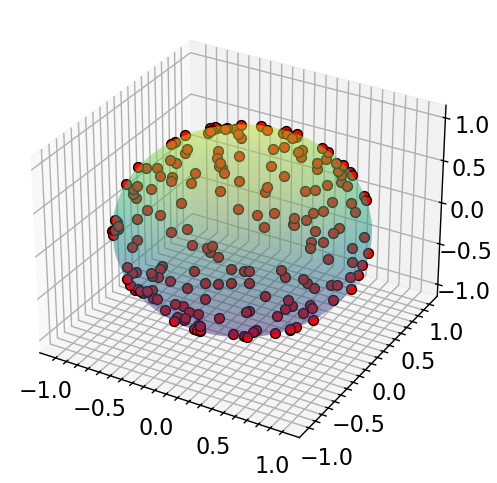

In [267]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Parameters for the sphere
radius = 1.0
theta = np.linspace(0, np.pi, 50)  # Polar angle
phi = np.linspace(0, 2 * np.pi, 50)  # Azimuthal angle
theta, phi = np.meshgrid(theta, phi)

# Spherical to Cartesian conversion
xc = radius * np.sin(theta) * np.cos(phi)
yc = radius * np.sin(theta) * np.sin(phi)
zc = radius * np.cos(theta)

# Plot a wireframe or surface
ax.plot_surface(xc, yc, zc, cmap='viridis', alpha=0.3, edgecolor='none')
#ax.grid(True)

# RANDOM POINT GENERATION
# https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere

for _ in range(200):
  xyz = np.random.normal(loc=0, scale=1, size=3)

  r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
  xyz = xyz / r
  ax.scatter(xyz[0], xyz[1], xyz[2], color='r', s=50, alpha=1, edgecolors='k')

plt.savefig('store/plots/sphere_plot_gaussian.png', dpi=300, bbox_inches='tight')

plt.show()

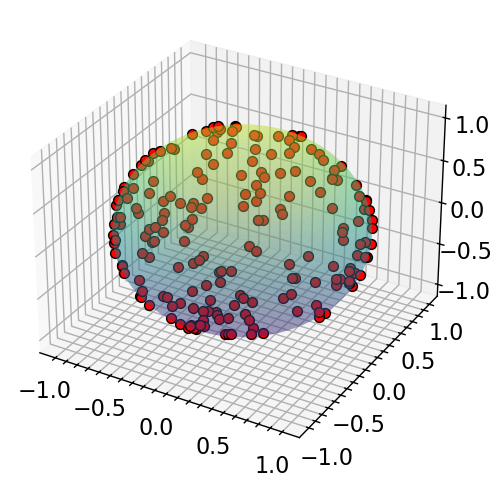

In [268]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Parameters for the sphere
radius = 1.0
theta = np.linspace(0, np.pi, 50)  # Polar angle
phi = np.linspace(0, 2 * np.pi, 50)  # Azimuthal angle
theta, phi = np.meshgrid(theta, phi)

# Spherical to Cartesian conversion
xc = radius * np.sin(theta) * np.cos(phi)
yc = radius * np.sin(theta) * np.sin(phi)
zc = radius * np.cos(theta)

# Plot a wireframe or surface
ax.plot_surface(xc, yc, zc, cmap='viridis', alpha=0.3, edgecolor='none')
#ax.grid(True)

# RANDOM POINT GENERATION
# https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere

for _ in range(200):
  phi = rd.uniform(0,2*np.pi)
  theta = np.arccos( rd.uniform(-1,1) )

  xcor = np.sin(theta) * np.cos(phi)
  ycor = np.sin(theta) * np.sin(phi)
  zcor = np.cos(theta)

  ax.scatter(xcor, ycor, zcor, color='r', s=50, alpha=1, edgecolors='k')

plt.savefig('store/plots/sphere_plot_direct.png', dpi=300, bbox_inches='tight')

plt.show()

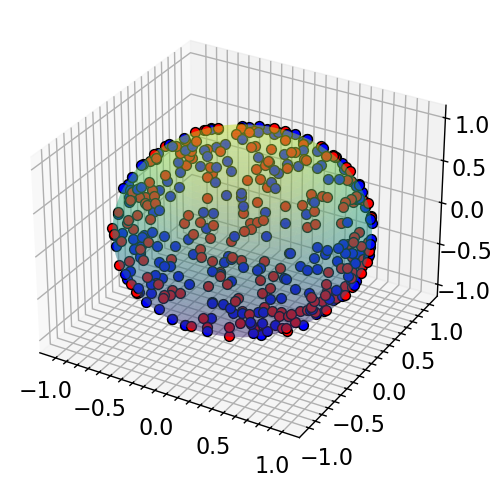

In [269]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Parameters for the sphere
radius = 1.0
theta = np.linspace(0, np.pi, 50)  # Polar angle
phi = np.linspace(0, 2 * np.pi, 50)  # Azimuthal angle
theta, phi = np.meshgrid(theta, phi)

# Spherical to Cartesian conversion
xc = radius * np.sin(theta) * np.cos(phi)
yc = radius * np.sin(theta) * np.sin(phi)
zc = radius * np.cos(theta)

# Plot a wireframe or surface
ax.plot_surface(xc, yc, zc, cmap='viridis', alpha=0.3, edgecolor='none')
#ax.grid(True)

# RANDOM POINT GENERATION
# https://math.stackexchange.com/questions/1585975/how-to-generate-random-points-on-a-sphere

for _ in range(200):
  xyz = np.random.normal(loc=0, scale=1, size=3)

  r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
  xyz = xyz / r
  ax.scatter(xyz[0], xyz[1], xyz[2], color='r', s=50, alpha=1, edgecolors='k')

plt.savefig('store/plots/sphere_plot_gaussian.png', dpi=300, bbox_inches='tight')

for _ in range(200):
  phi = rd.uniform(0,2*np.pi)
  theta = np.arccos( rd.uniform(-1,1) )

  xcor = np.sin(theta) * np.cos(phi)
  ycor = np.sin(theta) * np.sin(phi)
  zcor = np.cos(theta)

  ax.scatter(xcor, ycor, zcor, color='b', s=50, alpha=1, edgecolors='k')

plt.savefig('store/plots/sphere_plot_gaussanddirect.png', dpi=300, bbox_inches='tight')


plt.show()